# Visual-Area Autolabeler: Training

## About

[Noah C. Benson](nben@uw.edu)$^{1,2,3}$, [Shaoling Chen](sc6995@nyu.edu)$^{4}$, and [Jonathan Winawer](jonathan.winawer@nyu.edu)$^{1,2}$

$^1$Department of Psychology  
$^2$Center for Neural Sciences  
$^4$Courant Institute for Mathematics  
New York University  
New York, NY 10012

$^3$*Current Affiliation:*  
eScience Institute  
University of Washington  
Seattle, WA 98122

## Initialization

### Configuration

In [1]:
hcp_lines_path = None

genetic_data_path = None

behavioral_data_path = None

log_level = 'INFO'

valset_size = 32

image_size = 128

cache_path  = '/home/nben/tmp/hcp_resnet_cache'

resnet_path = '/home/nben/tmp/hcp_resnet_cache/resnet_training'

### Libraries

In [2]:
import os, sys, six, time, copy, pimms, pandas, PIL, cv2
import numpy as np
import scipy as sp
import nibabel as nib
import neuropythy as ny
import torch, torchvision, torchsummary

import matplotlib as mpl
import matplotlib.pyplot as plt
import ipyvolume as ipv

In [3]:
%matplotlib inline

In [4]:
# #TODO Later this will be removed when hcp-lines is integrated with
# neuropythy's datasets
hcppath = '/home/nben/code/hcp-lines'
if hcppath not in sys.path:
    sys.path.append(hcppath)
import hcp_lines

### Utilities

In [5]:
def constantly(x):
    '''
    constantly(x) yields a function f such that f(...) yields x, no matter what
    arguments are passed to f.
    '''
    def _lambda(*args, **kw):
        return x
    return _lambda

In [ ]:
def plot_prediction(dataset, k, model, axes=None, figsize=(6,1), dpi=72*4,
                    min_alpha=0.5):
    '''
    Plots the data, true label, and predicted label (by model) of dataset[k].
    '''
    (imdat, imlbl) = dataset[k]
    impre = torch.sigmoid(model(imdat[None,:,:,:].float()))
    impre = dataset.inv_transform(None, impre.detach()[0])
    (imdat, imlbl) = dataset.inv_transform(imdat, imlbl)
    if axes is None:
        (fig,axes) = plt.subplots(1, 3, figsize=figsize, dpi=dpi)
    # with imdat we want to adjust the alpha layer
    imdat = np.array(imdat)
    imdat[:,:,3] = imdat[:,:,3]*(1 - min_alpha) + min_alpha
    for (ax,im) in zip(axes, [imdat, imlbl, impre]):
        ax.imshow(np.clip(im, 0, 1))
        ax.axis('off')
    return axes

## Setup Data

### The HCP-Lines Dataset

In [ ]:
data = ny.data['hcp_lines']

Split into training and validation datasets

In [ ]:
# Filter out error subjects
sids = [sid for sid in data.subject_list
        if ('mean',sid,'lh') not in data.exclusions
        if ('mean',sid,'rh') not in data.exclusions]
sids = np.array(sids)
val_sids = np.random.choice(sids, valset_size)
trn_sids = np.setdiff1d(sids, val_sids)

### The PyTorch Dataset Class

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

default_image_size = 512

class HCPAnatomyDataset(torch.utils.data.Dataset):
    """
    HCPAnatomyDataset is a PyTorch dataset for the HCP. It produces 3xNx2N
    images of a subject's occipital poles (LH and RH) in which the three
    channels correspond to:
     (0) curvature (-1:1 is rescaled to 0:1)
     (1) sulcal depth (-2:2 is rescaled to 0:1)
     (3) cortical thickness (1:6 is rescaled to 0:1)    
    """
    def __init__(self, sids, image_size=default_image_size, cache_path=None,
                 downsample=2, use_func=False):
        """
        """
        self.sids = sids
        self.image_size = image_size
        self.cache_path = cache_path
        self.downsample = downsample
        self.use_func = use_func
        self._cache = {}
    def fwd_transform(self, inimg, outimg=None):
        """
        Applies pre-model-training transformations to the input and output
        images and yields the resulting images. If one of the images is
        passed as None, then only the other image is transformed and yielded.
        """
        if inimg is None and outimg is None: return None
        # The output image only needs to be to-tensor'ed
        if outimg is not None:
            tmp = np.asarray(outimg)
            hcols = tmp.shape[1] // 2
            outimg = np.zeros(tmp.shape[:2] + (6,), dtype=tmp.dtype)
            outimg[:,:hcols,:3] = tmp[:,:hcols]
            outimg[:,hcols:,3:] = tmp[:,hcols:]
            outimg = transforms.functional.to_tensor(outimg)
        # The input image needs to be normalized and to-tensor'ed
        if inimg is not None:
            #inimg = np.clip((inimg - 127.5) / 127.5, -1, 1)
            inimg = transforms.functional.to_tensor(inimg)
        return (outimg if inimg  is None else
                inimg  if outimg is None else (inimg, outimg))
    def inv_transform(self, inimg, outimg=None):
        """
        Applies pre-model-training inverse transformations to the input and
        output images, either of which may be None (see also fwd_transform).
        """
        if inimg is None and outimg is None: return None
        if outimg is not None:
            outimg = np.transpose(outimg.numpy(), (1,2,0))
            outimg = outimg[:,:,:3] + outimg[:,:,3:]
        if inimg is not None:
            #inimg = [np.clip(sl, -1, 1) * 127.5 + 127.5 for sl in inimg.numpy()]
            inimg = [np.clip(sl, 0, 1) for sl in inimg.numpy()]
            inimg = np.transpose(inimg, (1,2,0)).astype('float')
        return (outimg if inimg  is None else
                inimg  if outimg is None else (inimg, outimg))
    def __len__(self):
        return len(self.sids)
    def __getitem__(self, k):
        from skimage.transform import pyramid_reduce
        (p,f,s) = HCPAnatomyDataset.images(self.sids[k],
                                           image_size=self.image_size, 
                                           cache=self._cache,
                                           cache_path=self.cache_path)
        p = f if self.use_func else p
        return self.fwd_transform(p, s)
    def get(self, k):
        return HCPAnatomyDataset.images(self.sids[k],
                                        image_size=self.image_size, 
                                        cache=self._cache,
                                        cache_path=self.cache_path)
    @staticmethod
    def resize_image(im, image_size):
        """
        Yields the image resized to have the same number of rows as image_size.
        """
        from skimage.transform import pyramid_expand, pyramid_reduce
        im = np.asarray(im)
        imsz = im.shape[0]
        if imsz < image_size:
            im = pyramid_expand(im, image_size/imsz, multichannel=True)
        elif imsz > image_size:
            im = pyramid_reduce(im, imsz/image_size, multichannel=True)
        return im
    @staticmethod
    def images(sid, cache={}, image_size=default_image_size, cache_path=None):
        """
        Yields the (param, solution) images for the given subject-ID. If available,
        these images are loaded from cache or from the cache_path.
        """
        im = cache.get(sid, None)
        if im is not None: return im
        found = False
        if cache_path is not None:
            iflnm = os.path.join(cache_path, 'images', '%s_anat.png' % sid)
            fflnm = os.path.join(cache_path, 'images', '%s_func.png' % sid)
            oflnm = os.path.join(cache_path, 'images', '%s_v123.png' % sid)
            try:
                with PIL.Image.open(iflnm) as f: im = np.array(f)
                param = im
                with PIL.Image.open(fflnm) as f: im = np.array(f)
                fparam = im
                with PIL.Image.open(oflnm) as f: im = np.array(f)
                sol = im
                cache[sid] = (param, fparam, sol)
                found = True
            except Exception: pass
        # generate the images then...
        #if found and sol.shape[0] != default_image_size:
        #    found = False
        if not found:
            (param,fparam,sol) = HCPAnatomyDataset.generate_images(sid)
        (param,fparam,sol) = [HCPAnatomyDataset.resize_image(im, image_size)
                              for im in (param, fparam, sol)]
        # Put them in the cache and save them if possible
        cache[sid] = (param, fparam, sol)
        if cache_path is not None and not found:
            flnm = os.path.join(cache_path, 'images', '%s_anat.png' % sid)
            im = np.clip(param, 0, 255).astype('uint8')
            PIL.Image.fromarray(im).save(flnm)
            flnm = os.path.join(cache_path, 'images', '%s_func.png' % sid)
            im = np.clip(fparam, 0, 255).astype('uint8')
            PIL.Image.fromarray(im).save(flnm)
            flnm = os.path.join(cache_path, 'images', '%s_v123.png' % sid)
            im = np.clip(sol, 0, 255).astype('uint8')
            PIL.Image.fromarray(im).save(flnm)
        return (param, fparam, sol)
    anat_layers = {'curvature': (-1,1), 'convexity':(-2,2),
                   'thickness':(1,6),   'surface_area':(0,3)}
    func_layers = {'prf_polar_angle': (-180,180),
                   'prf_eccentricity':(0,12),
                   'prf_radius':(0,4),
                   'prf_variance_explained': (0,1)}
    @staticmethod
    def generate_images(sid, image_size=default_image_size,
                        anat_layers=Ellipsis, func_layers=Ellipsis):
        """
        Given a subject-id, generates and yields the tuple (param_image, sol_iamge)
        where param_image is the input image for the neural net and the sol_image
        is the output / solution to which the net should be trained.
        """
        dis = default_image_size
        if anat_layers is Ellipsis: anat_layers = HCPAnatomyDataset.anat_layers
        if func_layers is Ellipsis: func_layers = HCPAnatomyDataset.func_layers
        from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
        # Get the subject and make a figure.
        sub = ny.data['hcp_lines'].subjects[sid]
        ms  = {h:ny.to_flatmap('occipital_pole', sub[h]) for h in ['lh','rh']}
        ims = []
        for (p,(mn,mx)) in six.iteritems(anat_layers):
            (fig,axs) = plt.subplots(1,2, figsize=(2,1), dpi=dis)
            fig.subplots_adjust(0,0,1,1,0,0)
            fig.set_facecolor('k')
            for (h,ax) in zip(['lh','rh'], axs):
                ax.axis('off')
                ax.set_facecolor('k')
                ny.cortex_plot(ms[h], color=p, axes=ax,
                               cmap='gray', vmin=mn, vmax=mx)
            canvas = FigureCanvas(fig)
            canvas.draw()
            bufstr = canvas.tostring_rgb()
            plt.close(fig)
            image = np.frombuffer(bufstr, dtype='uint8')
            image = np.reshape(image, (dis, dis*2, 3))
            ims.append(image[:,:,0])
        param = np.transpose(ims, (1,2,0))
        # Repeat for the functional param image
        ims = []
        for (p,(mn,mx)) in six.iteritems(func_layers):
            (fig,axs) = plt.subplots(1,2, figsize=(2,1), dpi=dis)
            fig.subplots_adjust(0,0,1,1,0,0)
            fig.set_facecolor('k')
            for (h,ax) in zip(['lh','rh'], axs):
                ax.axis('off')
                ax.set_facecolor('k')
                # There is one special case: polar angle; we want to give the
                # rh and lh a similar map that is as non-circular as possible.
                if p.endswith('polar_angle'):
                    pp = ms[h].prop(p)
                    pp = -pp if h == 'rh' else pp
                    pp = np.mod(90 - pp + 180, 360) - 180
                else: pp = p
                ny.cortex_plot(ms[h], color=pp, axes=ax,
                               cmap='gray', vmin=mn, vmax=mx)
            canvas = FigureCanvas(fig)
            canvas.draw()
            bufstr = canvas.tostring_rgb()
            plt.close(fig)
            image = np.frombuffer(bufstr, dtype='uint8')
            image = np.reshape(image, (dis, dis*2, 3))
            ims.append(image[:,:,0])
        fparam = np.transpose(ims, (1,2,0))
        # Repeat for the solution image
        ims = []
        for lbl in [1,2,3]:
            (fig,axs) = plt.subplots(1,2, figsize=(2,1), dpi=dis)
            fig.subplots_adjust(0,0,1,1,0,0)
            fig.set_facecolor('k')
            for (h,ax) in zip(['lh','rh'], axs):
                ax.axis('off')
                ax.set_facecolor('k')
                ny.cortex_plot(ms[h], color=(ms[h].prop('visual_area') == lbl),
                               axes=ax, cmap='gray', vmin=0, vmax=1)
            canvas = FigureCanvas(fig)
            canvas.draw()
            bufstr = canvas.tostring_rgb()
            plt.close(fig)
            image = np.frombuffer(bufstr, dtype='uint8')
            image = np.reshape(image, (dis, dis*2, 3))
            ims.append(image[:,:,0])
        sol = np.transpose(ims, (1,2,0))
        return (param, fparam, sol)

To force the saving of all images, use this code block.

```python
def _force_sid(k):
    if k > len(sids): return False
    cache_path = '/home/nben/tmp/hcp_resnet_cache'
    dset = HCPAnatomyDataset(sids, cache_path=cache_path)
    im = dset.get(k)
    return True

import multiprocessing as mp
chunksz = 16
for k in range((len(sids) + chunksz - 1) // chunksz):
    with mp.Pool(chunksz) as pool:
        pool.map(_force_sid, range(chunksz*k, chunksz*(k+1)))
```

This cell creattes a few dictionary objects containing anatomical and/or functional data for both the training and validation sets.

In [ ]:
trn_sets = pimms.lmap(
    {'anat':lambda:HCPAnatomyDataset(trn_sids, cache_path=cache_path,
                                     use_func=False, image_size=image_size),
     'func':lambda:HCPAnatomyDataset(trn_sids, cache_path=cache_path,
                                     use_func=True, image_size=image_size)})
val_sets = pimms.lmap(
    {'anat':lambda:HCPAnatomyDataset(val_sids, cache_path=cache_path,
                                     use_func=False, image_size=image_size),
     'func':lambda:HCPAnatomyDataset(val_sids, cache_path=cache_path,
                                     use_func=True, image_size=image_size)})
datasets = pimms.persist({'trn': trn_sets, 'val': val_sets})

The following code loads one example dataset:

```python
(fnc,lbl) = datasets['val']['func'][0]
(fnc,lbl) = datasets['val']['func'].inv_transform(fnc, lbl)
```

In [ ]:
def make_dataloaders(dataset='func', shuffle=True, batch_size=2, **kw):
    '''
    make_dataloaders() yields training and validation dataloaders (in a
      dictionary whose keys are 'trn' and 'val'). The optional arguments
      `use_func` and `batch_size` may be given, and any other keyword
      arguments are ignored.
    '''
    return {
        k: DataLoader(sets[dataset], batch_size=batch_size, shuffle=shuffle)
        for (k,sets) in datasets.items()}

## Construct Model

In [ ]:
def convrelu(in_channels, out_channels, kernel, padding):
    return torch.nn.Sequential(
        torch.nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        torch.nn.ReLU(inplace=True))
class ResNetUNet(torch.nn.Module):
    def __init__(self, n_chan, n_class, pretrained_resnet=True):
        """
        ResNetUNet(input_channels, output_classes) yields an untrained PyTorch
        neural-network Module appropriate for training the V123 classification.
        """
        import torch.nn as nn
        super().__init__()
        
        self.pretrained_resnet = pretrained_resnet
        self.base_model = models.resnet18(pretrained=pretrained_resnet)
        if n_chan != 3:
            # adjust the first convolution's number of channels:
            c1 = self.base_model.conv1
            self.base_model.conv1 = nn.Conv2d(
                n_chan, c1.out_channels,
                kernel_size=c1.kernel_size, stride=c1.stride,
                padding=c1.padding, bias=c1.bias)

        self.base_layers = list(self.base_model.children())
        
        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)        
        self.layer1_1x1 = convrelu(64, 64, 1, 0)       
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)        
        self.layer2_1x1 = convrelu(128, 128, 1, 0)  
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)        
        self.layer3_1x1 = convrelu(256, 256, 1, 0)  
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)  
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)
        
        self.conv_original_size0 = convrelu(n_chan, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)
        
        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)        
        layer4 = self.layer4(layer3)
        
        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)
 
        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)
        
        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)        
        
        out = self.conv_last(x)
        
        return out

def resnet_model(pretrained=True, nclass=6, nchann=4, **kw):
    '''
    resnet_model() yields a ResNetUNet model object with 3 output classes and
      4 input channels. The `nclass` and `nchann` keywords can be used to
      alter the model, as well as the `pretrained` option. Keyword arguments
      not understood by the ResNetUNet class are ignored.
    '''
    return ResNetUNet(nchann, nclass, pretrained_resnet=pretrained)

## Model Training

In [ ]:
def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    return loss.mean()
def calc_loss(pred, target, metrics=None,
              bce_weight=0.5, smooth=0.5, save_path=None):
    '''
    calc_loss(pred, target) calculates the loss value between the given
      prediction and target/labels.
    '''
    # Apply sigmoid and dice loss
    bce = torch.nn.functional.binary_cross_entropy_with_logits(pred, target)
    dice = dice_loss(torch.sigmoid(pred), target, smooth=smooth)
    loss = bce * bce_weight + dice * (1 - bce_weight)
    if metrics is not None:
        metrics['bce']  += bce.data.cpu().numpy() * target.size(0)
        metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
        metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    return loss
log_header_format = "%-5s  %-7s  %-5s   %-8s  %-8s  %-8s   %-8s  %-8s  %-8s"
log_format = "%2d/%2d  %7.5f  %5.1f | %8.3f  %8.3f  %8.3f | %8.3f  %8.3f  %8.3f %s"
log_header = log_header_format % (
    "epoch", "  lr   ", "dt[s]",
    "trn bce ", "trn dice", "trn loss",
    "val bce ", "val dice", "val loss")
log_header_hline = log_header_format % (
    "="*5, "="*7, "="*5, "="*8, "="*8, "="*8, "="*8, "="*8, "="*8)
log_header_hline = log_header_hline.replace(' ', '-')
log_header_hline = "%s+%s+%s" % (
    log_header_hline[:22], log_header_hline[23:53], log_header_hline[54:])
def log_epoch(metrics, epochno=None, epochmax=None, lr=None, dt=None,
              logger=print, endl=""):
    '''
    log_epoch(metrics, epochno, lr, dt) logs an epoch's metrics.
    If metrics is None, then a header is printed. If metrics is Ellipsis, then
    a separator line is printed.
    '''
    if logger is None: return
    if metrics is None:
        logger(log_header)
        logger(log_header_hline)
    elif metrics is Ellipsis:
        logger('-' * len(log_header))
    else:
        t = metrics['trn']
        v = metrics['val']
        tup = ((epochno+1, epochmax, lr, dt) +
               tuple([t[q] for q in ['bce','dice','loss']]) +
               tuple([v[q] for q in ['bce','dice','loss']]) +
               (endl,))
        logger(log_format % tup)
def train_model(model, optimizer, scheduler, dataloaders, smooth=1.0,
                num_epochs=25, save_path=None, logger=print, bce_weight=0.5,
                device=None, hlines=False):
    '''
    train_model(model, optimizer, scheduler, dataloaders) runs training on the
      given model and returns the newly trained model. This represents a single
      set of epochs with a single StepLR decay.
    '''
    from collections import defaultdict
    if device is None:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    best_dice = 1e10
    log_epoch(None, logger=logger)
    for epoch in range(num_epochs):
        since = time.time()
        allmetrics = {}
        savestr = ""
        lr0 = optimizer.param_groups[0]['lr']
        # Each epoch has a training and validation phase
        for phase in ['trn', 'val']:
            if phase == 'trn':
                #scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            metrics = defaultdict(float)
            epoch_samples = 0
            for (inputs, labels) in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)             
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'trn'):
                    outputs = model(inputs.float())
                    loss = calc_loss(outputs, labels, metrics,
                                     bce_weight=bce_weight, smooth=smooth)
                    # backward + optimize only if in training phase
                    if phase == 'trn':
                        loss.backward()
                        optimizer.step()
                        scheduler.step()
                # statistics
                epoch_samples += inputs.size(0)
            for k in metrics.keys():
                metrics[k] /= epoch_samples
            epoch_loss = metrics['loss']
            # deep copy the model
            if phase == 'val':
                if epoch_loss < best_loss:
                    savestr = "*"
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                if metrics['dice'] < best_dice:
                    best_dice = metrics['dice']
            allmetrics[phase] = metrics
        time_elapsed = time.time() - since
        log_epoch(allmetrics, epoch, num_epochs, lr0, time_elapsed,
                  endl=savestr, logger=logger)
        if hlines: log_epoch(Ellipsis, logger=logger)
        if save_path is not None:
            torch.save(model.state_dict(), 
                       os.path.join(save_path, "model%06d.pkl" % epoch))
            torch.save(optimizer.state_dict(), 
                       os.path.join(save_path, "optim%06d.pkl" % epoch))
    if logger is not None: logger('Best val loss: {:4f}'.format(best_loss))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return (model, best_loss, best_dice)

In [ ]:
def run_model(make_model=resnet_model, make_dataloaders=make_dataloaders,
              num_epochs=20, lr=0.01, step_size=1, gamma=0.95,
              fine_tune=False, bce_weight=0.5, nthreads=26, nice=10,
              cache_path=resnet_path, logger=print, **kw):
    '''
    run_model() encapsulates the creation of the model and the model dataloaders
      as well as the train_model() function. Given a set of parameters for all
      of these functions, runs a single batch of epochs and yields the trained
      model.
    '''
    start_model = (make_model if isinstance(make_model, torch.nn.Module) else
                   make_model(**kw))
    torch.set_num_threads(nthreads)
    if nice is not None: os.nice(nice)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = start_model.to(device)
    dataloaders = make_dataloaders(**kw)
    # Freeze backbone layers
    # Comment out to finetune further
    for l in model.base_layers:
        for param in l.parameters():
            param.requires_grad = fine_tune
    optimizer_ft = torch.optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=lr)
    exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer_ft,
        step_size=step_size,
        gamma=gamma)
    return train_model(model, optimizer_ft, exp_lr_scheduler, dataloaders,
                       num_epochs=num_epochs, bce_weight=bce_weight,
                       save_path=cache_path, device=device, logger=logger)
    return model
def plan_to_model(initmdl, mdlplan, logger=print, cache_path=None):
    # A feature of plan_to_model is that it catches keyboard interrupts and
    # returns the current model!
    mdl = initmdl
    first = True
    best_dice = 1e10
    best_mdl = mdl
    best_mdl_wts = copy.deepcopy(mdl.state_dict())
    best_loss = 1e10
    for (ii,kw) in enumerate(mdlplan):
        if first: first = False
        elif logger is not None: logger("") # blank line between rounds
        if cache_path is not None:
            cpath = os.path.join(cache_path, 'round%02d' % (ii + 1,))
            if not os.path.isdir(cpath):
                os.makedirs(cpath, mode=0o755)
            kw['cache_path'] = cpath
        (mdl,loss,dice) = run_model(make_model=constantly(mdl),
                                    logger=logger, **kw)
        if dice < best_dice:
            best_dice = dice
            best_mdl = mdl
            best_mdl_wts = copy.deepcopy(mdl.state_dict())
            best_loss = loss
    best_mdl.load_state_dict(best_mdl_wts)
    return (best_mdl,best_loss,best_dice)

## Workspace

In [ ]:
True

### Testing the Model Code

In [16]:
#torchsummary.summary(resnet_model(), input_size=(4, 256, 512))

In [17]:
dataset = 'func'
pretrained = False

# We are using a batch size of 1 and want to reduce the learning rate
# only after we have been through each data-point once.
ntrn = len(datasets['trn'][dataset])
cpath = os.path.join(resnet_path, dataset)
# The plan for our training:
base_opts = {'batch_size': 1, 'step_size': ntrn, 'dataset':dataset}
training_plan = [
    dict(base_opts, lr=0.00375, gamma=0.9, num_epochs=10, fine_tune=False, bce_weight=0.67),
    dict(base_opts, lr=0.00375, gamma=0.9, num_epochs=10, fine_tune=True,  bce_weight=0.33),
    dict(base_opts, lr=0.00375, gamma=0.9, num_epochs=10, fine_tune=True,  bce_weight=0.00)
]

initial_model = resnet_model(pretrained=pretrained)
(trained_model, loss, dice) = plan_to_model(initial_model, training_plan,
                                            cache_path=cpath)

epoch    lr     dt[s]   trn bce   trn dice  trn loss   val bce   val dice  val loss
=====--=======--=====-+-========--========--========-+-========--========--========


KeyboardInterrupt: 

In [ ]:
plot_idcs = np.arange(6)

(fig,axs) = plt.subplots(len(plot_idcs), 3, figsize=(6, len(plot_idcs)), dpi=72*4)

for (axrow,idx) in zip(axs, plot_idcs):
    plot_prediction(datasets['val'][dataset], idx, trained_model, axes=axrow)

pass

In [ ]:
dataset = 'anat'
pretrained = False

# We are using a batch size of 1 and want to reduce the learning rate
# only after we have been through each data-point once.
ntrn = len(datasets['trn'][dataset])
cpath = os.path.join(resnet_path, dataset)
# The plan for our training:
base_opts = {'batch_size': 1, 'step_size': ntrn, 'dataset':dataset}
training_plan = [
    dict(base_opts, lr=0.00375, gamma=0.9, num_epochs=10, fine_tune=False, bce_weight=0.67),
    dict(base_opts, lr=0.00375, gamma=0.9, num_epochs=10, fine_tune=True,  bce_weight=0.33),
    dict(base_opts, lr=0.00375, gamma=0.9, num_epochs=10, fine_tune=True,  bce_weight=0.00)
]

initial_model = resnet_model(pretrained=pretrained)
(trained_model, loss, dice) = plan_to_model(initial_model, training_plan,
                                            cache_path=cpath)

In [ ]:
# Example subjects (the validation subject IDs are randomly chosen every time
# this notebook is run, so just pick a number of them).
plot_idcs = np.arange(6)

(fig,axs) = plt.subplots(len(plot_idcs), 3, figsize=(6, len(plot_idcs)), dpi=72*4)

for (axrow,idx) in zip(axs, plot_idcs):
    plot_prediction(datasets['val'][dataset], idx, trained_model, axes=axrow)

pass

### Hyper-parameter Grid Search

In [ ]:
grid_params = {
    'dataset': ['func','anat'],
    'batch_size': [1],
    'step_size': [len(datasets['trn']['func'])],
    'lr': [0.025,0.0125,0.008,0.005,0.00375,0.0025,0.00125],
    'gamma': [0.95, 0.9, 0.75, 0.5, 0.25],
    'pretrained': [True, False]}

grid = []
for (k,vs) in grid_params.items():
    if len(grid) == 0:
        grid = [{k:v} for v in vs]
    else:
        grid = [dict(u, **{k:v}) for u in grid for v in vs]

In [ ]:
import shutil

os.nice(10) # run these nicely!
cpath0 = os.path.join(resnet_path, 'grid')

for (ii,row) in enumerate(grid):
    if ii % 12 == 0:
        print("%3d of %-3d (%6.2f%%)" % (ii+1, len(grid), ii/(len(grid)-1)*100))
    tag = 'dat%04d' % (ii,)
    cpath = os.path.join(cpath0, tag)
    cfile = os.path.join(cpath0, tag + '.json')
    if os.path.isfile(cfile):
        for (k,v) in ny.load(cfile).items():
            row[k] = v
        continue
    mdl0 = resnet_model(pretrained=row['pretrained'])
    (mdl,loss,dice) = plan_to_model(mdl0, [row], cache_path=cpath, logger=None)
    row['tag'] = tag
    row['loss'] = loss
    row['dice'] = dice
    # Clear out the files that we don't need and resave the model and data
    ny.save(cfile, row)
    shutil.move(os.path.join(cpath,  'round01', 'optim000019.pkl'),
                os.path.join(cpath0, 'opt%04d.pkl' % ii))
    shutil.move(os.path.join(cpath,  'round01', 'model000019.pkl'),
                os.path.join(cpath0, 'mdl%04d.pkl' % ii))
    shutil.rmtree(cpath)    
    
grid = ny.to_dataframe(grid)

### Bayesian Inference

#### Utility Functions

###### General Utility Functions

In [149]:
def safesqrt(u):
    '''
    safesqrt(u) is equivalent to torch.sqrt(u) but only operates on values that
      are greater than 0.
    '''
    u = u + 0
    ii = u > 0
    u[ii] = torch.sqrt(u[ii])
    return u
def lbeta(a,b):
    '''
    lbeta(a,b) yields the log of the Beta function of x.
    This is equivalent to lgamma(a) + lgamma(b) - lgamma(a+b) using the lgamma
    function from pytorch.
    '''
    return torch.lgamma(a) + torch.lgamma(b) - torch.lgamma(a+b)
def beta_dist(mu, scale):
    '''
    beta_dist(mu, scale) yields the pytorch beta-distribution object(s) for the
      given mean mu and scale. The mu parameter must be between 0 and 1, and
      the scale parameter may be any real number.
      
    The traditional beta distribution uses parameters a and b. The
    reparameterizatoin of mu and scale here is as follows:
      a = (mu * (2 - b) - 1) / (mu - 1)
      b = (2 - 1/mu) + exp(scale)
    '''
    from torch.distributions import Beta
    b = torch.exp(scale)
    a = (mu * (b - 2) + 1) / (1 - mu)
    return Beta(a, b)
def beta_log_prob(mu, scale, x):
    '''
    beta_log_prob(mu, scale, x) yields the log probability density of the beta
      distribution parameterized using the mean mu (which must be between 0 and
      1) and scale (which may be any real number) at the value x.
      
    The traditional beta distribution uses parameters a and b. The
    reparameterizatoin of mu and scale here is as follows:
      a = (mu * (2 - b) - 1) / (mu - 1)
      b = (2 - 1/mu) + exp(scale)
    '''
    dist = beta_dist(mu, scale)
    return dist.log_prob(x)
def beta_pdf(mu, scale, x):
    '''
    beta_pdf(mu, scale, x) yields the probability density function of the beta
      distribution parrameterized using the mean mu (which must be between 0 and
      1) and scale (which may be any real number) at the value x.
    
    The traditional beta distribution uses parameters a and b. The
    reparameterizatoin of mu and scale here is as follows:
      a = (mu * (2 - b) - 1) / (mu - 1)
      b = (2 - 1/mu) + exp(scale)
    '''
    return torch.exp(beta_log_prob(mu, scale, x))
def limit_param(param, min=-1, max=1):
    '''
    limit_param(q) yields the parameter q rescaled to be in the range -1 to 1.
    limit_param(q, min, max) uses the given minimum and maximum parameters.
    '''
    import torch
    return min + (max - min) * (0.5 + torch.atan(param)/np.pi)
def unlimit_param(param, min=-1, max=1):
    '''
    unlimit_param(q, ...) is the inverse of limit_param(q, ...).
    '''
    import torch
    return torch.tan(np.pi * ((param - min) / (max - min) - 0.5))
def triarea(a,b,c):
    '''
    triarea(a,b,c) yields the area of the triangle whose sides have lengths
      a, b, and c.
    '''
    hp = 0.5*(a + b + c)
    return hp * (hp - a) * (hp - b) * (hp - c)
def dist2(xa,ya, xb,yb):
    '''
    dist2(xa,ya, xb,yb) yields the square distance between points a and b.
    '''
    return (xb - xa)**2 + (yb - ya)**2
def dist(xa,ya, xb,yb):
    '''
    dist(xa,ya, xb,yb) yields the distance between points a and b.
    '''
    return safesqrt(dist2(xa,ya,xb,yb))
def trisides2(xa,ya, xb,yb, xc,yc):
    '''
    trisides2(xa,ya, xb,yb, xc,yc) yields the squared lengths of the sides of
      the triangles formed by the given coordinates.
    '''
    return (dist2(xb,yb, xc,yc),
            dist2(xc,yc, xa,ya),
            dist2(xa,ya, xb,yb))
def trisides(xa,ya, xb,yb, xc,yc):
    '''
    trisides(xa,ya, xb,yb, xc,yc) yields the lengths of the sides of the
      triangles formed by the given coordinates.
    '''
    (a2,b2,c2) = trisides2(xa,ya, xb,yb, xc,yc)
    return (safesqrt(a2),
            safesqrt(b2),
            safesqrt(c2))
def trialtitudes(area, sides):
    '''
    trialtitudes(area, (a,b,c)) yields (ha, hb, hc), the altitudes of each
      side associated with the side-lengths, a,b,c.
    '''
    (a,b,c) = sides
    return (2*area/a, 2*area/b, 2*area/c)
def totensor(u, **kw):
    '''
    totensor(u) yields u if u is a pytorch tensor; otherwise, converts u to a
      pytorch tensor and yields that tensor. Keyword arguments to the tensor
      function may be passed, and, if passed, a copy of the u is always made
      when u is a tensor.
    '''
    import torch
    if torch.is_tensor(u):
        if len(kw) == 0: return u
        u = u.detach().numpy()
    dtype = kw.get('dtype', None)
    if dtype is None or dtype is torch.float:
        u = np.array(u, dtype='=f')
    else:
        tmp = torch.tensor(0.0, dtype=dtype)
        tmp = tmp.detach().numpy().dtype
        u = np.array(u, dtype=tmp)
    return torch.tensor(u, **kw)
def branch(iftensor, thentensor, elsetensor=None):
    '''
    branch(q, t, e) yields, elementwise for the given tensors, t if q else e.
    branch(q, t) or branch(q, t, None) yields, elementwise, t if q else 0.
    branch(q, None, e) yields, elementwise, 0 if q else e.
    
    The output tensor will always have the same shape as q. The values for t
    and e may be constants or tensors the same shape as q.

    This function should be safe to use in optimization, i.e., for gradient
    calculatioins.
    '''
    q = totensor(iftensor)
    t = None if thentensor is None else totensor(thentensor)
    e = None if elsetensor is None else totensor(elsetensor)
    x = t if e is None else e
    if x is None: raise ValueError('branch: both then and else cannot be None')
    r = torch.zeros(q.shape, dtype=x.dtype)
    if t is not None:
        if t.shape == (): r[q] = t
        else:             r[q] = t[q]
    if e is not None:
        q = ~q
        if e.shape == (): r[q] = e
        else:             r[q] = e[q]
    return r
def zinv(x):
    '''
    zinv(x) yields 0 if x == 0 and 1/x otherwise. This is done in a way that
      is safe for torch gradients; i.e., the gradient for any element of x that
      is equal to 0 will also be 0.
    '''
    x = totensor(x)
    ii = (x != 0)
    rr = torch.zeros(x.shape, dtype=x.dtype)
    rr[ii] = 1 / x[ii]
    return rr

###### Potential Steps and Wells

In [150]:
_area_stddev = 0.682689
def sin_step(t, width=1, min=0, max=1, center=0):
    '''
    sin_step(t) yields a sin-based sigmoid step such that:
      for t < -w0, sin_step(t) = 0, 
      for t > w0, sin_step(t) = 1,
      otherwise sin_step(t) = 1/2 (1 + sin(pi/2 w0 t)).
    sin_step(t, width) uses the given width; equivalent to sin_step(t/width).
    sin_step(t, width, min, max) uses the given min and max values instead of 0
      and 1.
    sin_step(t, width, min, max, center) centers the distribution at the given
      center value.
      
    The value w0 is based on the value s = 0.682689: approximately the fraction
    of the normal distribution within 1 standard deviation. The actual value of
    w0 is 2 arcsin(s) / pi; this particular value aligns the sin_step with the
    erf_step in that it ensures that ~68% of the distribution for which
    sin_step is the CDF is within -1 to +1.
    
    The sin_well is analogous to the sin_step; though the two are not related
    as PDF/CDF as with other *_well and *_step functions.
    '''
    import torch
    if center != 0: t = t - center
    t = t * (sin_step._w0 / width)
    step = 0.5 + 0.5*torch.sin(np.pi/2*t)
    step[t >  1] = 1
    step[t < -1] = 0
    return min + (max - min)*step
sin_step._w0 = 2.0 * np.arcsin(_area_stddev) / np.pi
def cauchy_step(t, width=1, min=0, max=1, center=0):
    '''
    cauchy_step(t) yields (pi + atan(pi/2 w0 t)) / (2 pi).
    cauchy_step(t, width) uses the given width parameter, equivalent to
      cauchy_step(t/width)
    cauchy_step(t, width, min, max) use the given min and max values, 
      equivalent to cauchy_step(t, width) * (max - min) + min.
      
    The value w0 is based on the value s = 0.682689: approximately the fraction
    of the normal distribution within 1 standard deviation. The actual value of
    w0 is tan(pi/2 s); this particular value aligns the atan_step with the
    erf_step in that it ensures that ~68% of the distribution for which
    atan_step is the CDF is within -1 to +1.
    
    The cauchy_well is analogous to the atan_step.
    '''
    t = totensor(t) - center
    const = cauchy_step._w0 / width
    u = 0.5 + torch.atan(t * const) / np.pi
    return u*(max - min) + min
cauchy_step._w0 = np.tan(np.pi/2 * _area_stddev)
def normal_step(t, width=1, min=0, max=1, center=0):
    '''
    normal_step(t) yields (1 + erf(t/w0))/2.
    normal_step(t, width) uses the given width parameter, equivalent to
      atansigmoid(t/width)
    normal_step(t, width, min, max) use the given min and max values, 
      equivalent to atansigmoid(t, width) * (max - min) + min.
    
    The value w0 is based on the value s = 0.682689: approximately the fraction
    of the normal distribution within 1 standard deviation. The actual value of
    w0 is 1/sqrt(2); this particular value ensures that 68% of the distribution
    for which erf_step is the CDF (i.e., a normal distribution) is within -1 to
    +1.
    
    The erf_step is analogous to the gaussian_well.
    '''
    t = totensor(t) - center
    t *= normal_step._w0 / width
    u = 0.5 + 0.5*torch.erf(t)
    return u * (max - min) + min
normal_step._w0 = 1.0/np.sqrt(2.0)
def logistic_step(t, width=1, min=0, max=1, center=0):
    '''
    logistic_step(t) yields 1/(1 + exp(-w0 t)).
    logistic_step(t, width) uses the given width parameter, equivalent to
      logistic_step(t/width)
    logistic_step(t, width, min, max) use the given min and max values, 
      equivalent to logistic_step(t, width) * (max - min) + min.
    
    The value w0 is based on the value s = 0.682689: approximately the fraction
    of the normal distribution within 1 standard deviation. The actual value of
    w0 is log(-(s+1)/(s-1)); this particular value aligns the logistic_step
    with the erf_step in that it ensures that ~68% of the distribution for which
    atan_step is the CDF is within -1 to +1.
    
    The logistic_step is analogous to the logistic_well.  
    '''
    t = totensor(t) - center
    t *= logistic_step._w0 / width
    u = 1/(1 + torch.exp(-t))
    return u * (max - min) + min
logistic_step._w0 = np.log(-(_area_stddev + 1) / (_area_stddev - 1))

In [151]:
_normaldist_hwhm = np.sqrt(np.log(4.0))
def sin_well(t, width=1, min=0, max=1, center=0):
    '''
    sin_well(t) yields a sin-based well function such that:
      * for t < -1/w0, sin_well(t) = 1
      * for -1/w0 <= t < 1/w0, sin_well(t) = 1/2 (1 - cos(pi/2 w0 t))
      * for 1/20 <= t, sin_well(t) = 1.
    sin_well(t, width) uses the given width; equivalent to sin_well(width*t); 
      the default value is 1.
    sin_well(t, width, min, max) is equivalent to:
       min + (max - min) * sin_well(t, width)
       
    The value w0 is chosen to make the sin-well approximately similar to a
    Gaussian-well in that the half-maximum point of both wells will be at the
    value log(sqrt(4)), which is where the half-way point occurs for a normal
    distribution. For a sin_well, this value if w0 is 1 / (2 log(sqrt(4))).
       
    sin_well(t) is equivalent to sin_well(t, width=1, min=0, max=1, center=0).
    '''
    import torch
    t = totensor(t) - center
    t *= sin_well._w0 / width
    well = 0.5 - torch.cos(np.pi * t)/2
    well[(t < -1) | (t >= 1)] = 1
    return well * (max - min) + min
sin_well._w0 = 0.5 / _normaldist_hwhm
def normal_well(t, width=1, min=0, max=1, center=0, base=0):
    '''
    normal_well(t) yields 1 - exp(-(t^2)/2).
    normal_well(t, width) is equivalent to normal_well(t / width)
    normal_well(t, width, min, max) is equivalent to
      normal_well(t, width) * (max - min) + min
    '''
    import torch
    t = (totensor(t) - center)
    t *= normal_well._w0 / width
    u = 1 - torch.exp(-0.5 * t**2)
    return u * (max - min) + min
normal_well._w0 = 1.0 #_normaldist_hwhm
def cauchy_well(t, width=1, min=0, max=1, center=0):
    '''
    caucht_well(t) yields 1 - 1/(1 + (w0 t)^2).
    cauchy_well(t, width) is equivalent to cauchy_well(t / width)
    cauchy_well(t, width, min, max) is equivalent to
      cauchy_well(t, width) * (max - min) + min.
      
    The value w0 is chosen to make the cauchy-well approximately similar to a
    Gaussian-well in that the half-maximum point of both wells will be at the
    value log(sqrt(4)), which is where the half-way point occurs for a normal
    distribution. For a cauchy_well, this value if w0 is 1 / log(sqrt(4)).
       
    cauchy_well(t) is equivalent to
    cauchy_well(t, width=1, min=0, max=1, center=0).
    '''
    t = (totensor(t) - center)
    t *= cauchy_well._w0 / width
    u = 1 - 1/(1 + t**2)
    return min + (max - min) * u
cauchy_well._w0 = 1.0 / _normaldist_hwhm
def logistic_well(t, width=1, min=0, max=1, center=0):
    '''
    logistic_well(t) yields 1 - 4 exp(-t)/(1 + exp(-t)).
    logistic_well(t, width) is equivalent to cauchy_well(t / width)
    logistic_well(t, width, min, max) is equivalent to
      logistic_well(t, width) * (max - min) + min
      
    The value w0 is chosen to make the logistic-well approximately similar to a
    Gaussian-well in that the half-maximum point of both wells will be at the
    value log(sqrt(4)), which is where the half-way point occurs for a normal
    distribution. For a sin_well, this value if w0 is
    log(3 + 2 sqrt(2)) / (2 log(sqt(4)))
       
    logistic_well(t) is equivalent to
    logistic_well(t, width=1, min=0, max=1, center=0).
    '''
    t = (totensor(t) - center)
    t *= logistic_well._w0 / width
    et = torch.exp(-t)
    u = 1 - 4*et/(1 + et)**2
    return u * (max - min) + min
logistic_well._w0 = np.log(3 + 2*np.sqrt(2.0)) / (2 * _normaldist_hwhm)

###### Log Probabilities for Common Distribution

In [209]:
def normal_log_prob(t, width=1, center=0):
    '''
    normal_log_prob(t) yields the log-probability of the normal 
      distribution: -t^2 / 2.
    normal_log_prob(t, w) is equivalent to normal_log_prob(t / w)
    normal_log_prob(t, w, center) is equivalent to 
      normal_log_prob(t - center, w)
    '''
    t = (totensor(t) - center)
    t /= width
    return -0.5 * t**2
def cauchy_log_prob(t, width=1, center=0):
    '''
    cauchy_log_prob(t) yields the log-probability of the cauchy
      distribution: -log(1 + t^2).
    cauchy_log_prob(t, w) is equivalent to cauchy_log_prob(t / w).
    cauchy_log_prob(t, w, center) is equivalent to
      cauchy_log_prob(t - center, w).
    '''
    t = (totensor(t) - center)
    t /= width
    return -torch.log1p(t**2)
def laplace_log_prob(t, width=1, center=0):
    '''
    laplace_log_prob(t) yields the log-probability of the Laplace
      distribution: -|t|
    laplace_log_prob(t, w) is equivalent to laplace_log_prob(t / w).
    laplace_log_prob(t, w, center) is equivalent to
      laplace_log_prob(t - center, w).
    '''
    t = (totensor(t) - center)
    t /= width
    return -torch.abs(t)
def exp_log_prob(t, width=1, center=0):
    '''
    exp_log_prob(t) yields the log-probability of the exponential
      distribution: -t for t >= 0 else 0
    exp_log_prob(t, w) is equivalent to exp_log_prob(t / w).
    exp_log_prob(t, w, center) is equivalent to exp_log_prob(t - center, w).
    '''
    t = (totensor(t) - center)
    t /= width
    return branch(t > 0, -t)
def generr_log_prob(q, t, width=1, center=0):
    '''
    generr_log_prob(q, t) yields the log-probability generalized error
      distribution: -|t|^q
    generr_log_prob(q, t, w) is equivalent to generr_log_prob(q, t / w).
    generr_log_prob(q, t, w, c) is equivalent to generr_log_prob(q, t - c, w).
    '''
    t = (totensor(t) - center)
    t /= width
    return -torch.abs(t)**q

#### Initializing Subject Data

In [153]:
@pimms.calc('cortex')
def init_hcp_cortex(sid, hemi):
    '''
    Calculation:
      (sid, h) => (cortex)
    Loads an HCP subject with the given subject id (sid), loads the given
    hemisphere (h), and yields it as the value 'cortex'.
    
    Afferent parameters:
     @ sid The HCP subject ID of the subject to use.
     @ hemi The name of the hemisphere to use--typically 'lh' or 'rh'.
    '''
    import neuropythy as ny
    sub = ny.hcp_subject(sid)
    return (sub.hemis[hemi],)
@pimms.calc('prior_angle', 'prior_eccen', 'prior_theta', 'prior_label')
def init_prior(cortex, prior_retinotopy=None, dtype=torch.float, device='cpu'):
    '''
    Calculation:
      (cortex, precalc_prior, dtype) => (prior_{angle,eccen,theta,label})
    Calculates the prior retinotopic maps for the given cortex object.
    
    Afferent parameters:
     @ prior_retinotopy A precalculated prior map as produced by neuropythy's
       predict_retinotopy() function with default options. If provided, the
       calculation of a prior is not needed.
     @ dtype The pytorch type to be used for all tensors (default: 
       torch.float).
     @ device The pytorch device name to be used for all tensors (default:
       'cpu').
    
    Efferent values:
     @ prior_angle The prior polar angle of each vertex on 'cortex' in
       neuropythy's 'visual' coordinate style (positive is clockwise, UVM is
       zero, units are degrees).
     @ prior_theta The prior polar angle of each vertex on 'cortex' in
       neuropythy's 'standard' coordinate style (positive is counter-clockwise,
       RHM is zero, units are radians).
     @ prior_eccen The prior eccentricity of each vertex on 'cotex' in
       visual degrees.
     @ prior_label The prior visual area label of each vertex on
       'cotex' represented as an integer real between 0 and 3 with 1, 2, and 3
       standing for V1, V2, and V3, respectively. Note that the label 0 takes
       on the visual-areea index 4 in the model implementation.
    '''
    import torch, neuropythy as ny
    if prior_retinotopy is None:
        prior_retinotopy = ny.vision.predict_retinotopy(cortex)
    (ang,ecc,lbl) = [np.array(prior_retinotopy[k])
                     for k in ('angle','eccen','varea')]
    tht = np.pi/180 * (np.mod(90 - ang + 180, 360) - 180)
    return (totensor(ang, dtype=dtype).to(device),
            totensor(ecc, dtype=dtype).to(device),
            totensor(tht, dtype=dtype).to(device),
            totensor(lbl, dtype=dtype).to(device))
@pimms.calc('meas_angle', 'meas_eccen', 'meas_theta', 'meas_prfsize',
            'meas_vexpl')
def init_meas(cortex, device, dtype, retinotopy='prf_'):
    '''
    Calculation:
      (cortex, retinotopy, dtype) => (meas_{angle,eccen,theta,prfsize,vexpl})
    Locates the measured retinotopy data.
    
    Afferent parameters:
     @ retinotopy The argument for neuropythy's retinotopy_data function; this
       is typically a string prefix for retinotopy data on the cortex's
       properties ('prf_' for HCP subjects), or a map of the data itself.
    
    Efferent values:
     @ meas_angle The measured polar angle of each vertex on 'cortex' in
       neuropythy's 'visual' coordinate style (positive is clockwise, UVM is
       zero, units are degrees).
     @ meas_theta The measured polar angle of each vertex on 'cortex' in
       neuropythy's 'standard' coordinate style (positive is counter-clockwise,
       RHM is zero, units are radians).
     @ meas_eccen The measured eccentricity of each vertex on 'cotex' in
       visual degrees.
     @ meas_vexpl The measured variance-explained (COD) of each vertex on
       'cotex' represented as a real number between 0 and 1.
     @ meas_prfsize The measured pRF size of each vertex on 'cotex' in visual
       degrees.
    '''
    import torch, neuropythy as ny
    rd = ny.vision.retinotopy_data(cortex, retinotopy)
    ang = np.array(rd['polar_angle'])
    ecc = np.array(rd['eccentricity'])
    vxp = np.array(rd['variance_explained'])
    rfs = np.array(rd['radius'])
    tht = np.pi/180 * (np.mod(90 - ang + 180, 360) - 180)
    return (totensor(ang, dtype=dtype).to(device),
            totensor(ecc, dtype=dtype).to(device),
            totensor(tht, dtype=dtype).to(device),
            totensor(rfs, dtype=dtype).to(device),
            totensor(vxp, dtype=dtype).to(device))
@pimms.calc('full_mesh', 'flatmap', 'mesh')
def init_mesh(cortex,
              meas_angle, meas_eccen, meas_theta, meas_vexpl, meas_prfsize,
              prior_angle, prior_eccen, prior_theta, prior_label,
              precalc_flatmap=None):
    '''
    Calculation:
      (cortex, prior_*, meas_*, precalc_flatmap) 
        => (full_mesh, flatmap, occpole_mesh)
    Loads the midgray mesh from the cortex object and limits it using a mask
    formed by the vertices in a spotlight flatmap of the occipital pole.
   
    Afferent parameters:
     @ cortex The neuropythy Cortex object (representing a hemisphere) to use.
     @ precalc_flatmap An optional flatmap to use instead of calculating a new
       flatmap using neuorpythy.to_flatmap('occipital_pole', cortex).
    
    Efferent values:
     @ full_mesh The migray mesh for the cortex being modeled.
     @ flatmap A flatmap of the occipital pole that has the same mask as the
       3D mesh on which the model is implemented (occpole_mesh and mesh).
     @ mesh The midgray surface mesh on which the model is implemented,
       limited to a spot-light mask of the occipital pole calculated using
       the vertices in flatmap.
    '''
    cortex = cortex.with_prop(
        prior_polar_angle=prior_angle,
        prior_eccentricity=prior_eccen,
        prior_theta=prior_theta,
        prior_label = prior_label,
        meas_polar_angle=meas_angle,
        meas_eccentricity=meas_eccen,
        meas_theta=meas_theta,
        meas_prfsize=meas_prfsize,
        meas_variance_explained = meas_vexpl)
    full_mesh = cortex.surface('midgray')
    if precalc_flatmap is None:
        precalc_flatmap = ny.to_flatmap('occipital_pole', cortex)
    else:
        p = dict(prior_polar_angle=prior_angle,
                 prior_eccentricity=prior_eccen,
                 prior_theta=prior_theta,
                 prior_label = prior_label,
                 meas_polar_angle=meas_angle,
                 meas_eccentricity=meas_eccen,
                 meas_theta=meas_theta,
                 meas_prfsize=meas_prfsize,
                 meas_variance_explained = meas_vexpl)
        for (k,v) in p.items():
            if torch.is_tensor(v): v = v.detach().numpy()
            p[k] = v[precalc_flatmap.labels]
        #p = {k: v[precalc_flatmap.labels] for (k,v) in p.items()}
        precalc_flatmap = precalc_flatmap.with_prop(**p)
    flatmap = precalc_flatmap
    mesh = full_mesh.submesh(flatmap.labels)
    return (full_mesh, flatmap, mesh)
@pimms.calc('faces', 'edges',
            'face_pairs', 'face_pair_edges', 'face_pair_opposites',
            'edge_lengths_mm', 'face_areas_mm2', 'vertex_areas_mm2')
def init_geometry(mesh, dtype, device):
    '''
    Calculation:
      (mesh) => (faces, edges, face_pairs, face_pair_opposites, edge_lenghts_mm,
                 face_areas_mm2, vertex_areas_mm2)
    Loads the midgray mesh from the cortex object and limits it using a mask
    formed by the vertices in a spotlight flatmap of the occipital pole.
   
    Efferent values:
     @ faces The 3 x n numpy arrary of the mesh vertex indices of each corner
       of its faces.
     @ edges The 2 x n numpy arrary of vertex indices in the mesh for each edge
       endpoint.
     @ face_pairs The 2 x n numpy array whose columns represent face indices
       are adjacent to each other. The indices of the edges that lie between
       each face pair is given by face_pair_edges.
     @ face_pair_edges The numpy array of edge indices that match the face
       pairs in the 'face_pairs' value. Each pair of faces that share an
       edge is given by the face inidices in face_pairs[k] and the edge 
       between them is given by the edge index in face_pair_edges[k].
     @ face_pair_opposites The 2 x n numpy array of mesh vetex indices of the
       vetices opposite each face in the face_pairs index. For a column k of
       face_pairs, the face indexed by face_pairs[k][0] is across the edge
       indexed by face_pair_edges[k] from the vertex indexed by
       face_pair_opposites[k][0]. The same is true for the face given by 
       ...[k][1].
     @ edge_lengths_mm The lengths of each edge in mesh in mm.
     @ face_areas_mm2 The cotical surface area of each face in mesh in square
       mm.
     @ vertex_areas_mm2 The cortical suface area of each vertex in mesh in
       square mm.
    '''
    edges = mesh.tess.indexed_edges.T
    faces = mesh.tess.indexed_faces.T
    # Figure out the face-pairs.
    (face_pairs,fp_edges) = np.transpose(
        [(k,ii) for (ii,k) in enumerate(mesh.tess.edge_faces) if len(k) == 2])
    f1other = np.squeeze([faces[f1, ~np.isin(faces[f1], faces[f2])]
                          for (f1,f2) in face_pairs])
    f2other = np.squeeze([faces[f2, ~np.isin(faces[f2], faces[f1])]
                          for (f1,f2) in face_pairs])
    fp_opps = np.array([f1other, f2other])
    fps = face_pairs.T
    # Get the edge lengths and triangle surface areas from the midgray surface.
    els = totensor(mesh.edge_lengths, dtype=dtype).to(device)
    fas = totensor(mesh.face_areas, dtype=dtype).to(device)
    vas = totensor(mesh.prop('midgray_surface_area'), dtype=dtype).to(device)
    return (faces.T, edges.T, fps, fp_edges, fp_opps, els, fas, vas)

init_subject_plan = pimms.plan(
    {'hcp_cortex': init_hcp_cortex,
     'prior':      init_prior,
     'meas':       init_meas,
     'mesh':       init_mesh,
     'geometry':   init_geometry})

#### The Retinotopy Model

##### Angle Coefficients

###### Explanation

Polar angle and visual area are stored simultaneously in one value: the angle coefficient. Angle coefficients range from -4 to 4 with the values indicating the following:
* `-1` and `+1` represent the LVM and UVM of V1, respectively (`0` represents the HM of V1).
* `-2` and `+2` represent the dorsal and ventral HM of V2/V3, respectively.
* `-3` and `+3` represent the LVM and UVM of V3, respectively.
* The remainder (out to `±4`) are buffer areas.

Conversion between an angle coefficient and a polar angle is done with the formula parameters:
* `uvm_ipsilateral` (also represented as `ui`) is the deviation of the UVM polar angle from the true vertical (&pi;/2). For example if this value is 0.07, then the polar angle values of the upper vertical meridian are expected to be (&pi;/2 + 0.07).
* `lvm_ipsilateral` (also represented as `li`) is the same deviation for the LVM polar angle from the true vertical (&pi;/2). Whereas the UVM value is given in counter-clockwise radians, this value is given in clockwise radians.
* `angle_sigma` is a value that determines the bleedover between visual areas at the boundaries. Because we propose to fit the model to the data using gradient descent optimization, we don't want hard visual-area boundaries at the V1/V2, V2/V3, etc. edges. Accordingly, vertices near the edges are considered to be a weighted combination of both visual areas with the higher weight for the area that is closer. The weights are determined by step-like functions that employ the error-function as a sigmoid.

The following visual-area values can be computed using the above `angle_sigma` parameter and the angle coefficients. For angle coefficient $t$, the following are the visual-area pseudo-labels:
* $w(t; \sigma, s_0, s_1) = \frac{1}{2}\left(\hbox{erf}\left((t + s_0)/\sigma\right) - \hbox{erf}\left((t - s_1)/\sigma\right)\right)$
* $v_1(t; \sigma) = w(t; \sigma, -1, 1)$
* $v_2(t; \sigma) = w(t; \sigma, -2, -1) + w(t; \sigma, 1, 2)$
* $v_3(t; \sigma) = w(t; \sigma, -3, -2) + w(t; \sigma, 2, 3)$
* $v_4(t; \sigma) = w(t; \sigma, -4, -3) + w(t; \sigma, 3, 4)$

Given these values, we can calculate the predicted angle value for an angle coefficient. The formula for the predicted polar angle $\theta$, calculated from the angle coefficient $t$ using parameters $u$ (`uvm_ipsilateral`) and $l$ (`lvm_ipsilateral`) and the visual-area label $q$ (which must be 1, 2, 3, or 4) is as follows:

$$
\bar{\theta}(t; u, l, q) = \begin{cases}
    (\pi/2 + u) (t - q + 1) & t > 0 \\
    (\pi/2 + l) (t + q - 1) & t \leq 0
    \end{cases}
$$

The predicted polar angle for a specific angle coefficient can be found by summing across visual areas with the window functions as weights:

$$
\theta(t; \sigma, u, l) = \sum_{k=1}^4 v_k(t; \sigma) \bar{\theta}(t; u, l, k)
$$

###### Core Funnctions

In [154]:
def varea_window(t, sigma, s0, s1):
    '''
    varea_window(t, sigma, s0, s1) is a smooth step-function described by:
       𝑤(𝑡; 𝜎, 𝑠0, 𝑠1) = 1/2 (erf((𝑡+𝑠0)/(2𝜎/π)) − erf((𝑡−𝑠1)/(2𝜎/π)))
    or:
       0.5 * (erf((t + s0)/(sigma/pi*2)) - erf((t - s1) / (sigma/pi*2)))
       
    Note that sigma is divided by pi/2 because it is assumed to be expressed in
    radians whereas there are approximately pi radians in 2 units of the
    theta-coefficient t.
    '''
    sigma = sigma / (np.pi / 2)
    return 0.5 * (torch.erf((t - s0) / sigma) - torch.erf((t - s1) / sigma))
def varea_1(t, label_sigma=0.1):
    '''
    varea_1(t, sigma) yields the v1 label weight for theta-coefficient t.
    '''
    return varea_window(t, label_sigma, -1.0, 1.0)
def varea_2(t, label_sigma=0.1):
    '''
    varea_2(t, sigma) yields the v2 label weight for theta-coefficient t.
    '''
    return varea_window(t, label_sigma, -2.0, -1.0) + varea_window(t, label_sigma, 1.0, 2.0)
def varea_3(t, label_sigma=0.1):
    '''
    varea_3(t, sigma) yields the v3 label weight for theta-coefficient t.
    '''
    return varea_window(t, label_sigma, -3.0, -2.0) + varea_window(t, label_sigma, 2.0, 3.0)
def varea_4(t, label_sigma=0.1):
    '''
    varea_4(t, sigma) yields the v4-like label weight for theta-coefficient t.
    '''
    return 1.0 - varea_window(t, label_sigma, -3.0, 3.0)
def vareas(t, label_sigma=0.1):
    '''
    Yields a 5-tuple of (varea_1, varea_2, varea_3, varea_4, varea_sum).
    '''
    ws = (varea_1(t, label_sigma=label_sigma),
          varea_2(t, label_sigma=label_sigma),
          varea_3(t, label_sigma=label_sigma),
          varea_4(t, label_sigma=label_sigma))
    wtot = ws[0] + ws[1] + ws[2] + ws[3]
    return ws + (wtot,)
def _bartheta(t, q, ui=0.09, li=0.17):
    '''
    _bartheta(t, q) calculates the piecewise bar-theta parameter (see above cells).
    '''
    hpi = np.pi/2
    gt = t > 0
    le = ~gt
    res = torch.zeros(t.shape)
    if q > 0:
        res[gt] = (hpi + ui) * (t[gt] - q + 1)
        res[le] = (hpi + li) * (t[le] + q - 1)
    else:
        q *= -1
        res[gt] = (hpi + ui) * (1 - (t[gt] - q + 1))
        res[le] = (hpi + li) * (-1-(t[le] + q - 1))
    return res
def theta(t, vas, ui=0.09, li=0.17):
    '''
    theta(t,vas) calculates the polar angle theta from the angle-coefficient t
      and the visual areas vas (see vareas()). The return value is in radians
      that increase in the counter-clockwise direction with 0 as the RHM.
    '''
    return (vas[0]*_bartheta(t,  1, ui=ui, li=li) +
            vas[1]*_bartheta(t, -2, ui=ui, li=li) +
            vas[2]*_bartheta(t,  3, ui=ui, li=li) +
            vas[3]*_bartheta(t, -4, ui=ui, li=li) ) / vas[4]
def theta_rescaled(t, vas):
    '''
    theta_rescaled(t, vas) is equivalent to theta(t, vas) except that it
      excludes any upper or lower visual-field ipsilateral stretching. This
      value is appropriate for use with the cortical magnification model.
    '''
    return (vas[0]*_bartheta(t,  1, ui=0, li=0) +
            vas[1]*_bartheta(t, -2, ui=0, li=0) +
            vas[2]*_bartheta(t,  3, ui=0, li=0) +
            vas[3]*_bartheta(t, -4, ui=0, li=0) ) / vas[4]
def prior_anglecoef(angles, vareas):
    '''
    prior_anglecoef(angles, vareas) yields the angle coefficients of the
      polar angles and visual area labels. Note that this is expected to
      be called with arguments from the retinotopic prior or similar, so
      angles should be in 'visual' orientation (clockwise is positive,
      UVM is 0°) and vareas should be a vector of labels (1 for V1, 2
      for V2, etc.)
    
    Yields torch tensors.
    '''
    if torch.is_tensor(angles): angles = angles.detach().numpy()
    if torch.is_tensor(vareas): vareas = vareas.detach().numpy()
    angles = (np.mod(90 - angles + 180, 360) - 180) / 90
    c = torch.full(np.shape(angles), 4.0, dtype=torch.float)
    q = np.ones(c.shape, dtype='bool')
    for (ll,ks) in zip([1,2,3,4], [[1],[2],[3],[4,7,11,12]]):
        ii = np.isin(vareas, ks)
        q[ii] = False
        angs = angles[ii]
        if ll%2 == 0:
            c[ii] = torch.tensor(np.sign(angs)*(ll) - angs, dtype=torch.float)
        else:
            c[ii] = torch.tensor(np.sign(angs)*(ll - 1) + angs, dtype=torch.float)
    # Fill in the rest as ± 4's.
    sgns = np.sign(angles[q])
    sgns[sgns == 0] = 1
    c[q] = torch.tensor(4.0 * sgns, dtype=torch.float)
    return c

###### Demo

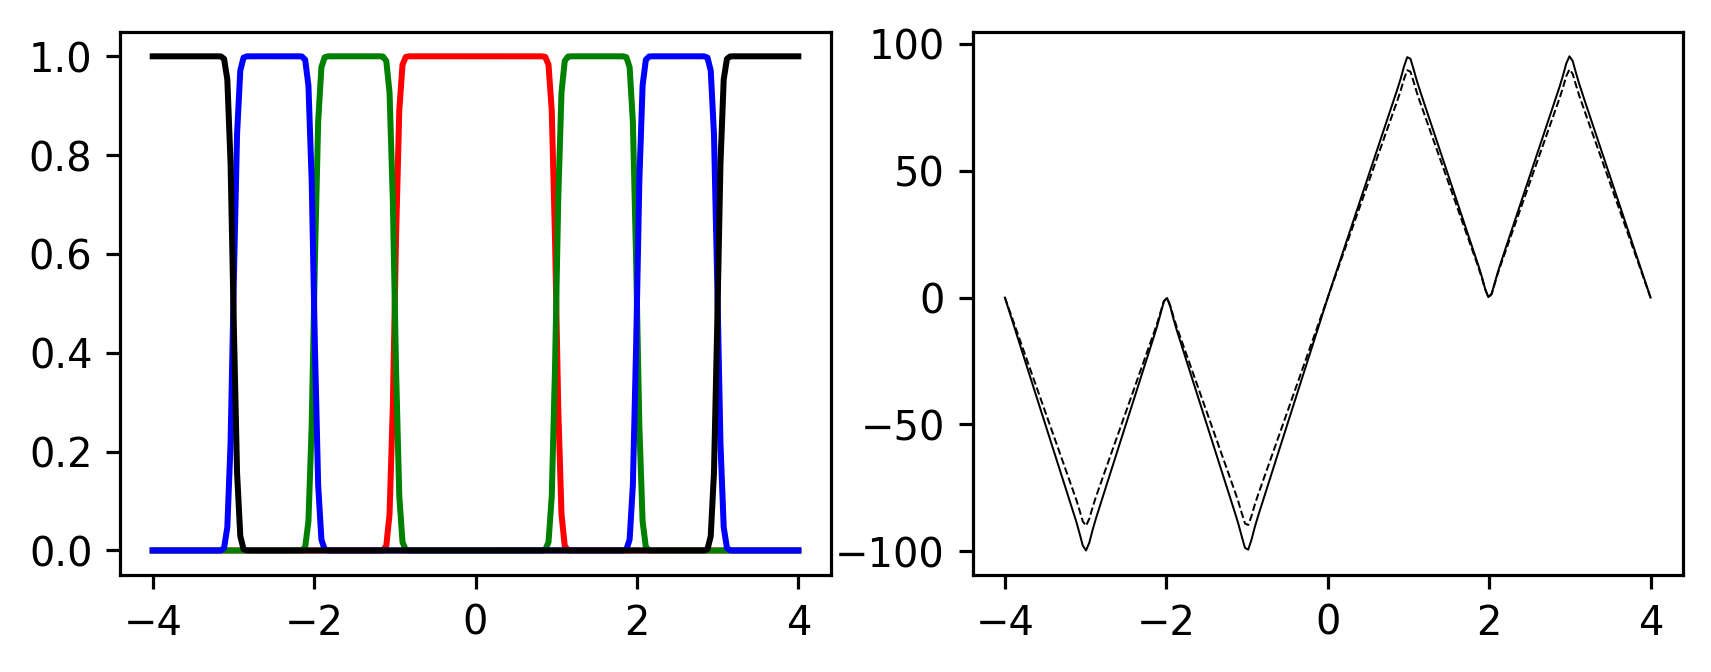

In [155]:
(fig,axs) = plt.subplots(1, 2, figsize=(7, 2.5), dpi=72*4)

x = torch.tensor(np.linspace(-4.0, 4.0, 200), dtype=torch.float)
vas = vareas(x)
ax = axs[0]
ax.plot(x, vas[0], 'r-')
ax.plot(x, vas[1], 'g-')
ax.plot(x, vas[2], 'b-')
ax.plot(x, vas[3], 'k-')

ax = axs[1]
ax.plot(x, 180/np.pi*theta(x, vas), 'k-', lw=0.5)
ax.plot(x, 180/np.pi*theta_rescaled(x, vas), 'k--', lw=0.5)

pass

###### Calculation and Plan Code

In [207]:
@pimms.calc('anglecoef', 'eccen')
def init_coords(prior_angle, prior_eccen, prior_label, mesh,
                dtype, device, coords_grad=True, gradients={}):
    '''
    Calculation:
      (prior_angle, prior_eccen, prior_label, coords_grad) 
        => (anglecoef, eccen)
    Converts the prior polar angle, eccentricity, and visual area label into
    the initial angle-coefficient and eccentricity values to be used in the
    model calculation and, potentially, minimization.
    
    Afferent parameters:
     @ coords_grad True if the polar angle and eccentricity coordinates
       represented in anglecoef and eccen should have required gradient
       calculations. The default is True. If False, this essentially means that
       any minimization that is performed will not attempt to optimize the
       individual vertex parameters.
     @ gradients A (mutable) dict of pytorch tensors produced during the
       initialization of the model code for which gradient calculations were
       required. Duing initialization, various calculations append to this
       gradient with their parameter names as keys. If the entire model is
       run, i.e., by requesting the potential, then this dictionary will
       contain all the parameters that depend on a gradient. These may be
       touched in the imap to force recalculation of the potential values
       and meta-data when optimizing.
    
    Efferent values:
     @ anglecoef The pytorch tensor containing the angle-coefficient for each
       vertex in mesh. The angle coefficient is a shorthand for representing
       the range of polar angles and visual areas in V1, V2, and V3 and is
       explained in more detail in the notebook that accompanies this code.
     @ eccen The pytorch tensor containing the eccentricity of each vertex in
       mesh.
    '''
    ang = prior_anglecoef(prior_angle, prior_label)
    ecc = prior_eccen.detach().numpy()[mesh.labels]
    ang = ang.detach().numpy()[mesh.labels]
    ang = totensor(ang, dtype=dtype, requires_grad=coords_grad).to(device)
    ecc = totensor(ecc, dtype=dtype, requires_grad=coords_grad).to(device)
    if coords_grad:
        gradients['anglecoef'] = ang
        gradients['eccen'] = ecc
    return (ang, ecc)
@pimms.calc('uvm_ipsilateral_free', 'lvm_ipsilateral_free',
            'hva_free', 'vma_free', 'label_sigma_free')
def init_anglecoef_params(dtype, device, gradients,
                          prior_uvm_ipsilateral=0.09,
                          prior_lvm_ipsilateral=0.17,
                          prior_hva=0.5,
                          prior_vma=0.5,
                          prior_label_sigma=0.10,
                          uvm_ipsilateral_lim=(-0.3,0.3),
                          lvm_ipsilateral_lim=(-0.3,0.3),
                          hva_lim=(-1.0,1.0),
                          vma_lim=(-1.0,1.0),
                          label_sigma_lim=(0.01, 0.5),
                          ipsilateral_grad=False,
                          asymmetry_grad=False,
                          label_sigma_grad=False):
    '''
    Initializes the model parameters required to interpret the 
    angle-coefficient of each vertex into polar angle and visual area label
    properties. This calculation initializes the "free" versions of the
    parameters--i.e., the versions that can range from -inf to inf but that get
    limited into a particular range for the actual model calculation.
    
    Afferent parameters:
     @ prior_uvm_ipsilateral The initial value of the UVM ipsilateral visual
       field fraction in the retinotopy model.
     @ prior_lvm_ipsilateral The initial value of the LVM ipsilateral visual
       field fraction in the retinotopy model.
     @ prior_hva The initial value of the horizontal-vertical asymmetry ratio
       in the model. This is conceptually:
       2 (horiz_cmag - vert_cmag) / (horiz_cmag + vert_cmag)
     @ prior_vma The initial value of the horizontal-vertical asymmetry ratio
       in the model. This is conceptually:
       2 (lower_cmag - upper_cmag) / (lower_cmag + upper_cmag)
     @ prior_label_sigma The initial value of the visual areal label's sigma
       value. This controls how much the properties of one visual area bleeds
       into the next visual area at the boundaries.
     @ uvm_ipsilateral_lim The (min, max) values that the uvm_ipsilateral
       parameter is allowed to take in the retinotopy model.
     @ lvm_ipsilateral_lim The (min, max) values that the lvm_ipsilateral
       parameter is allowed to take in the retinotopy model.
     @ hva_lim The (min, max) values that the hva parameter is allowed to take
       in the retinotopy model.
     @ vma_lim The (min, max) values that the vma parameter is allowed to take
       in the retinotopy model.
     @ label_sigma_lim The (min, max) values that the label_sigma parameter is
       allowed to take in the retinotopy model.
     @ ipsilateral_grad True if the uvm and lvm ipsilateral representation
       parameters should be updated in gradient steps; otherwise, the
       parameters are treated as constants.
     @ asymmetry_grad True if the hva and vma (asymmetry) parameters should be
       updated in gradient steps; otherwise, the parameters are treated as
       constants.
     @ label_sigma_grad True if the label_sigma parameter should be updated in
       gradient steps; otherwise, the parameter is treated as a constant.
       
    Efferent values:
     @ uvm_ipsilateral_free The free/unlimited version of the UVM ipsilateral
       fraction parameter. As a free parameter, the value may be any real
       number; the limited version is calculated using the CDF of a normal
       distribution.
     @ lvm_ipsilateral_free The free/unlimited version of the LVM ipsilateral
       fraction parameter. As a free parameter, the value may be any real
       number; the limited version is calculated using the CDF of a normal
       distribution.
     @ hva_free The free/unlimited version of the horizontal-vertical asymmetry
       parameter. As a free parameter, the value may be any real number; the
       limited version is calculated using the CDF of a normal distribution.
     @ vma_free The free/unlimited version of the upper-lower vertical
       asymmetry parameter. As a free parameter, the value may be any real
       number; the limited version is calculated using the CDF of a normal
       distribution.
     @ label_sigma_free The free/unlimited version of the label_sigma
       parameter. As a free parameter, the value may be any real number; the
       limited version is calculated using the CDF of a normal distribution.
    '''
    tups = [
        ('uvm_ipsilateral_free', uvm_ipsilateral_lim, prior_uvm_ipsilateral, ipsilateral_grad),
        ('lvm_ipsilateral_free', lvm_ipsilateral_lim, prior_lvm_ipsilateral, ipsilateral_grad),
        ('hva_free',             hva_lim,             prior_hva,             asymmetry_grad),
        ('vma_free',             vma_lim,             prior_vma,             asymmetry_grad),
        ('label_sigma_free',     label_sigma_lim,     prior_label_sigma,     label_sigma_grad)]
    rval = {}
    for (k,(mn,mx),pri,grad) in tups:
        pri_free = unlimit_param(totensor(pri), mn, mx)
        u = torch.tensor(pri_free.detach().numpy(),
                         dtype=dtype,
                         requires_grad=grad)
        u = u.to(device)
        if grad: gradients[k] = u
        rval[k] = u
    return rval
@pimms.calc('uvm_ipsilateral', 'lvm_ipsilateral',
            'hva', 'vma', 'label_sigma')
def calc_anglecoef_params(uvm_ipsilateral_free,
                          lvm_ipsilateral_free,
                          hva_free,
                          vma_free,
                          label_sigma_free,
                          uvm_ipsilateral_lim,
                          lvm_ipsilateral_lim,
                          hva_lim,
                          vma_lim,
                          label_sigma_lim):
    '''
    Calculates the model parameters required to interpret the 
    angle-coefficient of each vertex into polar angle and visual area label
    properties from the free (unlimited/gradient-safe) parrameters. This
    calculation involves running the free versions of each pameter through the
    arctangent function in order to convert an infinite range to the range
    (0,1) then linearly expanding that to the parameter's limit.
    
    Efferent values:
     @ uvm_ipsilateral The range-limited translation of uvm_ipsilateral_free
       based on uvm_ipsilateral_lim. The UVM ipsilateral fraction is the
       fraction of the ipsilateral visual field that is represented along the
       ventral visual area boundaries in cortex.
     @ lvm_ipsilateral The range-limited translation of lvm_ipsilateral_free
       based on lvm_ipsilateral_lim. The LVM ipsilateral fraction is the
       fraction of the ipsilateral visual field that is represented along the
       dorsal visual area boundaries in cortex.
     @ hva The range-limited translation of hva_free based on hva_lim. The
       horizontal-vertical asymmetry is conceptually:
       2 (horiz_cmag - vert_cmag) / (horiz_cmag + vert_cmag)
     @ vma The range-limited translation of hva_free based on vma_lim. The
       vertical meridian asymmetry is conceptually:
       2 (lower_cmag - upper_cmag) / (lower_cmag + upper_cmag)
     @ label_sigma The range-limited translation of label_sigma_free based on
       label_sigma_lim. The label_sigma is the constant multiplier used in
       the error-function (erf) used to calculate visual area weights. See
       the calc_anglecoef_metaparams calculator for more details.
    '''
    tups = [
        (uvm_ipsilateral_lim, uvm_ipsilateral_free),
        (lvm_ipsilateral_lim, lvm_ipsilateral_free),
        (hva_lim,             hva_free),
        (vma_lim,             vma_free),
        (label_sigma_lim,     label_sigma_free)]
    (uvmi, lvmi, hva, vma, lsig) = [limit_param(free, mn, mx)
                                    for ((mn,mx),free) in tups]
    return (uvmi, lvmi, hva, vma, lsig)
@pimms.calc('theta', 'theta_rescaled', 'varea_weights')
def calc_anglecoef_data(anglecoef, label_sigma,
                        uvm_ipsilateral, lvm_ipsilateral,
                        dtype, device):
    '''
    Calculates the values theta, theta_rescaled, and the visual-area weights
    (varea_weights) for each vertex in the model based on the angle-coefficient
    and the model parameters label_sigma, and uvm_/lvm_ipsilateral.
    
    Efferent values:
     @ theta The predicted "true" polar angle representation of the pRF of each
       vertex in the retinotopy model. The value is in radians with the RHM at
       0 and positive pointing in the counter-clockwise direction.
     @ theta_rescaled The predicted polar angle rescaled to be contained in the
       right horizontal visual field; this is occasionally useful when polar
       angle is part of a model, but the UVM/LVM ipsilateral fraction isn't
       explicitly part of the subcomponent of the model.
     @ varea_weights A 4-tuple of the (non-visual, v1, v2, v3) area weights of
       the model. The weight for each area is the predicted fraction of the
       vertex that is classified as part of the relevant visual area.
    '''
    vas = vareas(anglecoef, label_sigma=label_sigma)
    tht = theta(anglecoef, vas, ui=uvm_ipsilateral, li=lvm_ipsilateral)
    thr = theta_rescaled(anglecoef, vas)
    # We reorganize and normalize the va's
    w = vas[4]
    tns = torch.zeros((len(vas) - 1, len(vas[0])), dtype=dtype)
    for (ii,vv) in zip(range(tns.shape[0]), [3,0,1,2]):
        tns[ii,:] = vas[vv]/w
    vas = tns.to(device)
    return (tht, thr, vas)
@pimms.calc('pred_theta')
def calc_pred_theta(theta):
    '''
    Calculates the predicted pRF polar angle, i.e., the prediction of what the
    pRF theta (polar angle) measurements will be.
    
    Efferent values:
     @ pred_theta The predicted measurement of pRF polar angle associated with
       each vertex, according to the retinotopy model. This is different from
       the 'theta' value in that 'theta' is the model's predicted true
       polar angle while 'pred_theta' is the model's prediction of the
       measured poler angle. In the current model, however, these are the
       same.  
    '''
    return (theta,)
@pimms.calc('pred_label')
def calc_pred_label(varea_weights):
    '''
    Calculates the predicted visual area label based on the visual area
    weights.
    
    Efferent values:
     @ pred_label The predicted visual area label associated with each
       vertex, according to the retinotopy model.
    '''
    return torch.argmax(varea_weights, axis=0)
@pimms.calc('zsign')
def calc_zsign(anglecoef, eccen, faces):
    '''
    Calculates the z-sign value for each face in the model mesh.
    
    Efferent values:
     @ zsign The z-sign value of each face in the model mesh. The z-sign is
       conceptually similar to the field-sign but is calculated from the eccen
       and anglecoef parameters instead of the true pRF centers, meaning that
       there should always only be a single z-sign for all of V1-V3. The value
       calculated for triangle (a,b,c) is (b-a) x (c-a).
    '''
    (a,b,c) = faces
    tht = (anglecoef * np.pi/2 / 4)
    (x,y) = (eccen*torch.cos(tht), eccen*torch.sin(tht))
    (x_ab,y_ab) = (x[b] - x[a], y[b] - y[a])
    (x_ac,y_ac) = (x[c] - x[a], y[c] - y[a])
    z = x_ab*y_ac - x_ac*y_ab
    return (z,)

In [208]:
init_anglecoef_plan = pimms.plan(
    {'init_coords': init_coords,
     'init_anglecoef_params': init_anglecoef_params})
calc_anglecoef_plan = pimms.plan(
    {'calc_anglecoef_params': calc_anglecoef_params,
     'calc_anglecoef_data': calc_anglecoef_data,
     'calc_pred_theta': calc_pred_theta,
     'calc_pred_label': calc_pred_label,
     'calc_zsign': calc_zsign})
anglecoef_plan = pimms.plan(init_anglecoef_plan,
                            calc_anglecoef_plan)

##### Cortical Magnification Model

###### Explanation

The model of cortical magnification used here combines Horton and Hoyt's (1991) model of cortical magnification in terms of eccentricity with a model of tangential magnification asymmetry.

* `hva` is the horizontal-vertical asymmetry, which is the fraction of the mean c.mag. at the horizontal and vertical meridians that the vertical meridian alone contributes to--usually this is about 0.5.
* `vma` is the vertical meridian asymmetry, which is the fraction of the mean c.mag. at the vertical meridians that the upper vertical meridian alone contributes to--usually this is about 0.5.

Given these values, we can calculate the cortical magnification, in terms of the rescaled polar angle ($\theta_r$), which represents the polar angle in traditional radians (increasing counter-clockwise with the origin at the positive x-axis) but has been rescaled such that +&pi; represents &pi;+`ui` and -&pi; represnts -&pi;-`li`.

$$
\gamma(\mathbf{\theta_r}; \mathbf{hva}, \mathbf{vma}) = 1 + \frac{1}{2}\left(\mathbf{hva} \cos(2 \mathbf{\theta_r}) - \mathbf{vma} \, \hbox{sgn}(\sin(\mathbf{\theta_r})) \sin(\mathbf{\theta_r})^2 \right)
$$

With Horton and Hoyt's (1991) equation, this gives us the following magnification in terms of corrected polar angle and eccentricity:

$$
m(\mathbf{\theta_r}, \mathbf{\rho}; c_1, c_2, \hbox{hva}, \hbox{vma}) = \gamma(\mathbf{\theta_r}; \hbox{hva}, \hbox{vma}) \left( \frac{c_1}{c_2 + \mathbf{\rho}} \right)^2
$$

The integral of this equation over half of the visual field (i.e., the area of the visual area) out to $M$ degrees of is:

$$ \hat{a}(M) = \int_{\theta_r=-\pi/2}^{\theta_r=pi/2} \int_{\rho=0}^{\rho=M} \rho \, m(\theta_r, \rho) \, d\rho\,d\theta_r $$
$$ \hat{a}(M) = c_1^2 \pi \left(\log\left(\frac{c_2 + M}{c_2}\right) - \frac{M}{c_2 + M}\right) $$

This is, in fact, the integral for the Horton and Hoyt (1991) equation alone, indicating that the tangential multiplier does not change the overall cortical magnification of an individual visual area. Assuming that we know that the actual surface area of the visual-area from 0 to `M` degrees of eccentricity is $a_M$, we can fix the parameter $c_1$ to force the equation to have a fixed total surface area:

$$ c_1 = \sqrt{\frac{a_M}{\pi \left(\log\left(\frac{c_2 + M}{c_2}\right) - \frac{M}{c_2 + M}\right)}} $$

The variable $M$ above is generally named as `max_eccen` in the code. It represents is the maximum eccentricity value assumed to be included in V1, $M$ (generally kept as 90°).

###### Core Functions

In [158]:
def cmmdl_tan_multiplier(theta, ui=0.09, li=0.17, hva=0.5, vma=0.5):
    '''
    Yields the angular cortical magnification multiplier based on the polar
      angle theta, which is measured in counter-clockwise degrees from the HM.
    '''
    hpi = np.pi/2
    th = torch.zeros(theta.shape)
    gt = theta > 0
    lt = ~gt
    th[gt] = theta[gt] / (hpi + ui) * hpi
    th[lt] = theta[lt] / (hpi + li) * hpi
    hvpart = hva * torch.cos(2 * th)
    thsin  = torch.sin(th)
    ulpart = vma * torch.sign(thsin) * thsin**2
    return 1.0 + 0.5*(hvpart - ulpart)
def cmmdl_hhcmag(eccen, c1=17.3, c2=0.75):
    '''
    cmmdl_radcmag(eccen) yields the linear radial cortical magnification using
      the Horton and Hoyt (1991) formula.
    '''
    return c1 / (c2 + eccen)
def cmmdl_hhcmag2(eccen, c1=17.3, c2=0.75):
    '''
    cmmdl_hhcmag2(eccen) yields the areal radial cortical magnification using
      the Horton and Hoyt (1991) formula.
    '''
    return cmmdl_hhcmag(eccen)**2
def cmmdl_cmag2(theta, eccen,
                c1=17.3, c2=0.75, ui=0.09, li=0.17, hva=0.5, vma=0.5):
    '''
    Yields the areal cortical magnification prediction for the given polar
      angle and eccentricity using both the Horton and Hoyt (1991) equation
      as well as the tangential cortical magnification multiplier.
    '''
    rmag = cmmdl_hhcmag2(eccen, c1=c1, c2=c2)
    tmlt = cmmdl_tan_multiplier(theta, ui=ui, li=li, hva=hva, vma=vma)
    return rmag * tmlt
def cmmdl_c1(area, max_eccen, c2):
    '''
    Yields the value of c1 in the cmmdl that is appropriate for a visual area
    with the given surface-area, within the given max_eccen central degrees,
    and the parameter c2.
    '''
    c2_maxecc = c2 + max_eccen
    den = np.pi * (torch.log(c2_maxecc / c2) - max_eccen / c2_maxecc)
    return safesqrt(area / den)

###### Demo

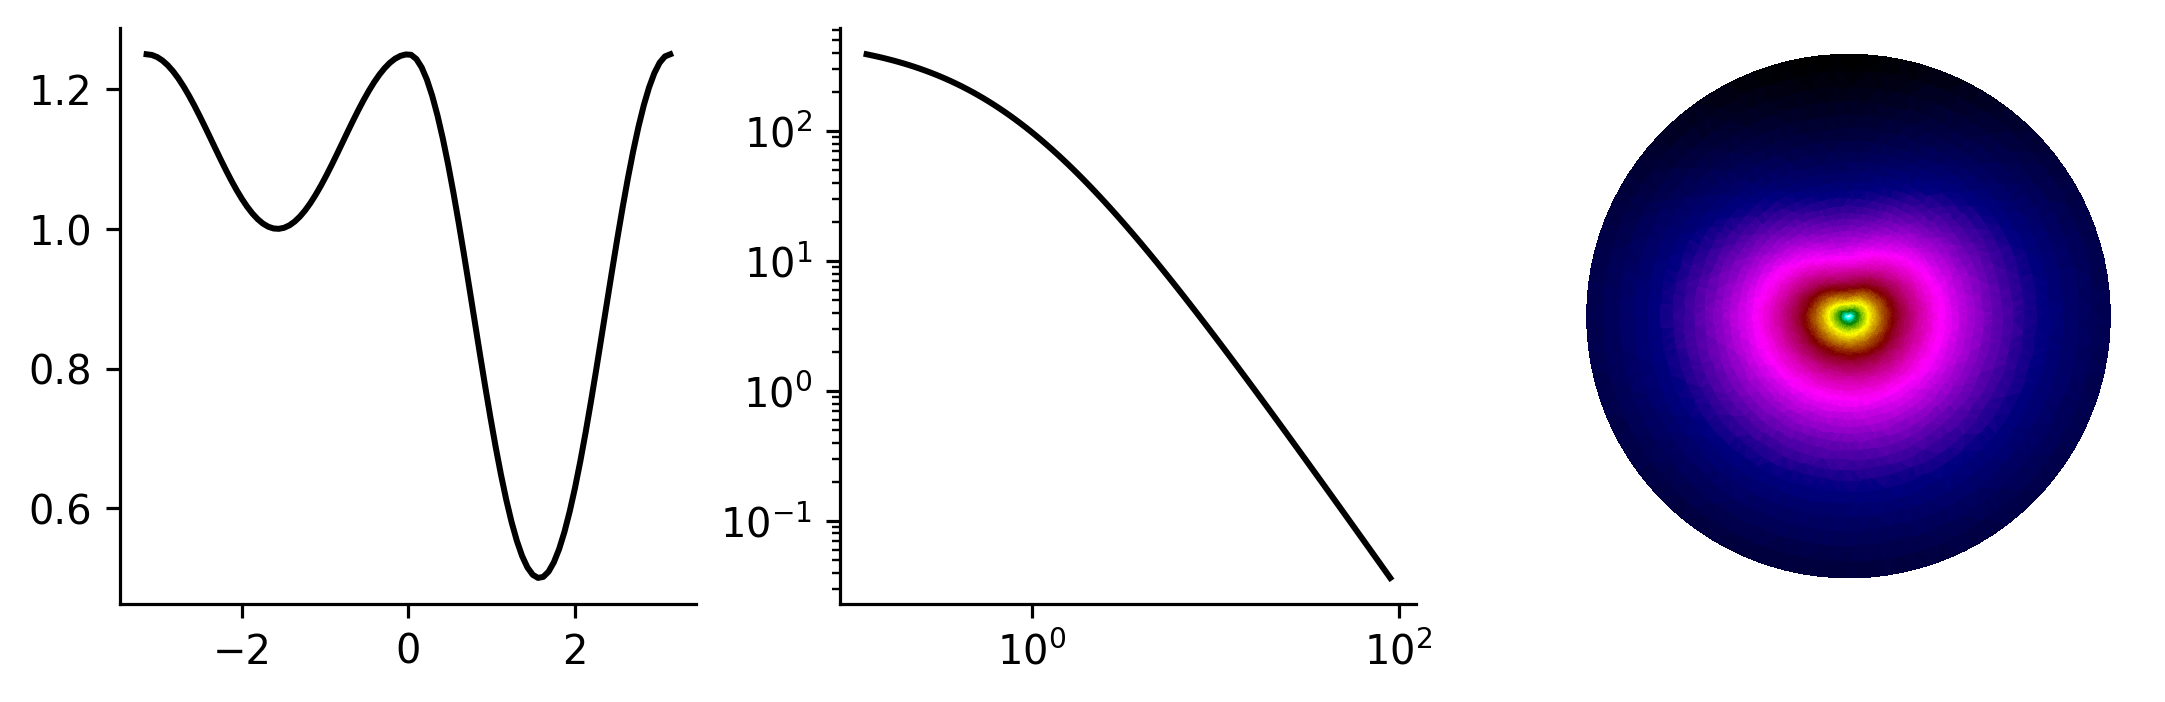

In [159]:
(fig, axs) = plt.subplots(1, 3, figsize=(7, 2), dpi=72*4)
fig.subplots_adjust(0,0,1,1,0.25,0)
for ax in axs:
    for sp in ['top','right']:
        ax.spines[sp].set_visible(False)

t = np.linspace(-np.pi, np.pi, 100)
mult = cmmdl_tan_multiplier(torch.tensor(t, dtype=torch.float), ui=0, li=0).detach().numpy()
axs[0].plot(t, mult, 'k-')

r = np.logspace(-3, np.log2(90.0), 100, base=2)
cm2 = cmmdl_hhcmag2(r)
axs[1].loglog(r, cm2, 'k-')

(r,t) = np.meshgrid(r, t)
(r,t) = (r.flatten(), t.flatten())
(x,y) = (r*np.cos(t), r*np.sin(t))
cm2 = cmmdl_cmag2(torch.tensor(t, dtype=torch.float),
                  torch.tensor(r, dtype=torch.float))
tri = mpl.tri.Triangulation(x, y)
axs[2].tripcolor(x, y, torch.log(cm2), cmap='log_eccentricity')
axs[2].axis('equal')
axs[2].axis('off')

pass

###### Calculation and Plan Code

In [196]:
@pimms.calc('gradients')
def init_gradients():
    '''
    Initializes an empty (mutable!) dictionary for tracking the elements of the
    model that are part of the gradient descent.
    '''
    return ({},)
@pimms.calc('cmag_eccen_offset_free', 'prfsize_gain_free')
def init_cmag_params(dtype, gradients,
                     prior_cmag_eccen_offset=(1.0, 0.75, 0.70, 0.65),
                     prior_prfsize_gain=(8.0, 5.0, 6.0, 7.0),
                     cmag_eccen_offset_lim=(0.01, 2.5),
                     prfsize_gain_lim=(0.05, 100.0),
                     cmag_grad=True,
                     prfsize_grad=True):
    '''
    Initializes the model parameters required to calculate the cortical
    magnification of each vertex and/or visual field position. This
    calculation initializes the "free" versions of the cmag_eccen_offset
    parameters--i.e., the version that can range from -inf to inf but that gets
    limited into a particular range for the actual model calculation.
    
    Afferent parameters:
     @ prior_cmag_eccen_offset The initial value of the offset parameter c2 
       from Horton and Hoyt's (1991) equation cmag(ecc) = c1 / (c2 + ecc).
       This should be a tensor of 4 values for visual areas (none, v1, v2, v3).
     @ cmag_eccen_offset_lim The (min, max) values that the cmag_eccen_offset
       parameter is allowed to take in the retinotopy model.
     @ prior_prfsize_gain The initial value of the gain parameter g that
       is divided by the cortical magnification in order to predict the pRF
       size for a visual area. This should be a tuple of 4 values for visual
       areas (none, v1, v2, v3).
     @ prfsize_gain_lim The (min, max) values that the prfsize_gain parameter
       is allowed to take in the retinotopy model.
       
    Efferent values:
     @ cmag_eccen_offset_free The free/unlimited version of the cortical
       magnification offset parameter. As a free parameter, the value may be
       any real number; the limited version is calculated using the CDF of the
       acrtangent function.
     @ prfsize_gain_free The free/unlimited version of the pRF size gain
       parameter. As a free parameter, the value may be any real number; the
    '''
    tups = [
        ('cmag_eccen_offset_free', cmag_eccen_offset_lim, prior_cmag_eccen_offset, cmag_grad),
        ('prfsize_gain_free',      prfsize_gain_lim,      prior_prfsize_gain,      prfsize_grad)]
    rval = {}
    for (k,(mn,mx),pri,grad) in tups:
        if len(pri) != 4:
            raise ValueError('prior for %s must be a length 4 tuple' % (k,))
        pri_free = unlimit_param(totensor(pri), mn, mx)
        print(k, pri, mn, mx, pri_free)
        if pri_free.shape == ():
            pri_free = torch.ones(4, dtype=dtype)*pri_free
        u = torch.tensor(pri_free.detach().numpy(),
                         dtype=dtype,
                         requires_grad=grad)
        if grad: gradients[k] = u
        rval[k] = u
    return rval
@pimms.calc('cmag_eccen_offset', 'prfsize_gain')
def calc_cmag_params(cmag_eccen_offset_free,
                     prfsize_gain_free,
                     cmag_eccen_offset_lim,
                     prfsize_gain_lim):
    '''
    Calculates the model parameters required to calculate the cortical
    magnification of each vertex and/or visual field position. This
    calculation involves running the free versions of each pameter through the
    arctangent function in order to convert an infinite range to the range
    (0,1) then linearly expanding that to the parameter's limit.
    
    Efferent values:
     @ cmag_eccen_offset The range-limited translation of the
       cmag_eccen_offset_free parameter based on cmag_eccen_offset_lim. The
       eccentricity offset in the cortical magnification model is the value for
       the parameter c2 in Horton and Hoyt's (1991) cortical magnification
       equation: cmag(eccen) = (c1 / (c2 + eccen))^2.
       This parameter should be a 4-tensor of the parameters for the visual
       areas (none, v1, v2, v3).
     @ prfsize_gain The range-limited translation of the prfsize_gain_free
       parameter based on prfsize_gain_lim. The prfsize_gain together with
       the cortical magnification of a point in the visual field determines
       the predicted pRF size: prfsize = gain / sqrt(cmag).
       This parameter should be a 4-tensor of the parameters for the visual
       areas (none, v1, v2, v3).
    '''
    tups = [(cmag_eccen_offset_lim, cmag_eccen_offset_free),
            (prfsize_gain_lim,      prfsize_gain_free)]
    (eo,sg) = [limit_param(free, mn, mx) for ((mn,mx),free) in tups]
    return (eo, sg)
@pimms.calc('cmag_scale')
def calc_cmag_scale(eccen, varea_weights, cmag_eccen_offset,
                    max_stim_eccen, vertex_areas_mm2, dtype):
    '''
    Calculates the 'cmag_scale' meta-parameter for each visual area.
    
    Efferent values:
     @ cmag_scale The meta-parameter (c1) that can be calculated from the
       'cmag_eccen_offset' (c2) parameter and the total visual area size,
       based on the fact that the cortical magnification used in the model
       conforms to Horton and Hoyt's (1991) equation:
       cmag2(ecc) = (c1 / (c2 + ecc))^2.
       The calculation of cmag_scale uses the surface area of the region of
       each visual area that is within max_stim_eccen to calculate the
       parameter value.
    '''
    q = (eccen < max_stim_eccen)
    szs = [torch.sum(branch(q, vertex_areas_mm2*ws)) for ws in varea_weights]
    r = torch.zeros((len(varea_weights), len(eccen)), dtype=dtype)
    for (ii,(sz,c2)) in enumerate(zip(szs, cmag_eccen_offset)):
        r[ii] = cmmdl_c1(sz, max_stim_eccen, c2)
    return (r,)

In [197]:
cmag_plan = pimms.plan(
    {'init_gradients': init_gradients,
     'init_cmag_params': init_cmag_params,
     'calc_cmag_params': calc_cmag_params,
     'calc_cmag_scale': calc_cmag_scale})

##### PRF Size Model

###### Explanation

The pRF size is determined by offset and scale parameters $b_k$ and $\gamma_k$ for each visual area $k$. The pRF size $s$ is:

$$ s(\rho; b, \gamma) = b + \gamma \rho $$

There is good reason to think that pRF size should be inversely related to cortical magnification, with the product of the two equalling a constant in each visual area. The particular value of the constant must likely vary both with voxel size as well as visual area. For this reason, we can use the coefficients from the cortical magnification equation directly.

$$ s_k(\theta, \rho) = \frac{g_k}{\sqrt{m(\theta, \rho)}} $$

However, a major disruption in the pRF size is that the stimulus edge interacts with the pRF estimates. Any voxel whose true pRF overlaps with the stimulus edge is confusable with another voxel on the other side of the stimulus edge whose pRF also overlaps with a similar amount of the stimulus. This means that a few things can happen near the stimulus edge:

1. The measured pRF sizes can drop
2. The measured eccentricity can decrease

Both of these occur because the true pRF, under limited stimulus, can be modeled with a smaller less eccentric pRF. The effect can be modeled as follows, where $s$ is the true (predicted) pRF size, $\hat{s}$ is the prediction of the measured pRF size, and $\hat{\rho}$ is the prediction of the measured eccentricity. Both of these functions use the weights $w_k(\theta, \rho; \psi)$ where $\psi$ is the max stimulus eccentricity.

$$ w_k(\theta, \rho; \psi) = \frac{1}{2}\left( 1 - \hbox{erf}\left(\frac{\rho - (\psi - s_k(\theta, \psi)}{s_k(\theta, \psi)/2}\right) \right) $$

$$ \hat{s}_k(\theta, \rho) = \frac{1}{2} \left( \left[\rho + s_k(\theta, \rho)\right][1 - w_k(\theta, \rho; \psi)] + \psi \, w_k(\theta, \rho; \psi) - [\rho - s_k(\theta, \rho)] \right) $$

###### Core Functions

In [162]:
def rfmdl_prfsize(cmag2, gain):
    '''
    Yields the predicted true pRF size for the given cortical magnification
      predictions and the visual-area's gain.
    '''
    return gain / safesqrt(cmag2)
def rfmdl_stimweight(rho, prfsz, max_stim_eccen):
    '''
    Yields the stimulus weight at the given eccentricities (rho) for the
      given pRF size and max stimulus eccentricity.
    '''
    num = rho - (max_stim_eccen - prfsz)
    den = prfsz / 2
    return (1 - torch.erf(num / den)) / 2
def rfmdl_meas_prfsize(rho, prfsz, stimweight, max_stim_eccen):
    '''
    Yields the predicted measured pRF sizes for the given eccentricities,
      true pRF sizes, and the maximum stimulus eccentricity.
    '''
    w = stimweight
    t1 = rho + prfsz
    t2 = max_stim_eccen
    t3 = rho - prfsz
    return 0.5*(t1*w + t2*(1 - w) - t3)

###### Demo

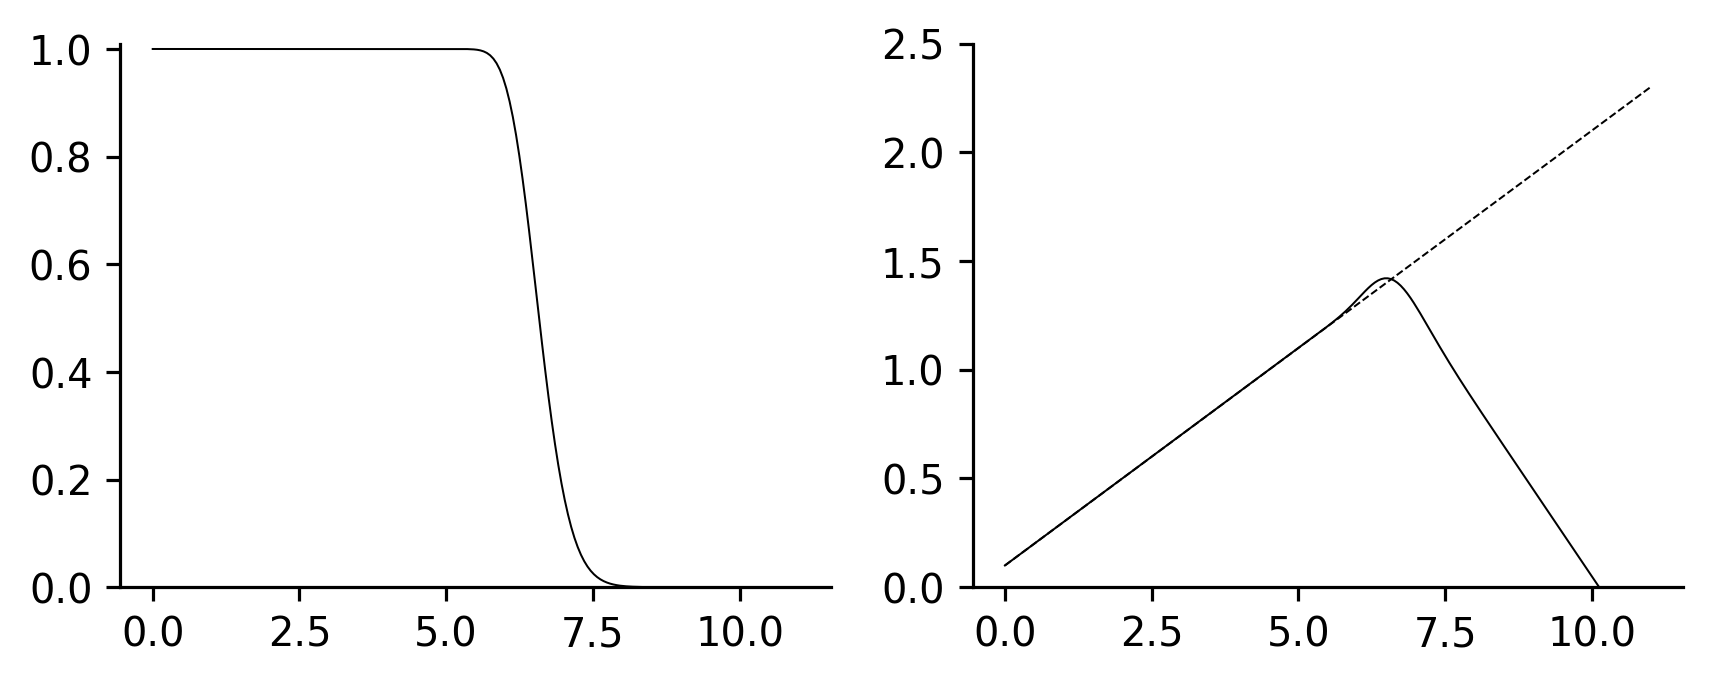

In [163]:
(fig,axs) = plt.subplots(1, 2, figsize=(7, 2.5), dpi=72*4)
#fig.subplots_adjust(0,0,1,1,0.25,0)
for ax in axs:
    for sp in ['top','right']:
        ax.spines[sp].set_visible(False)


rho = torch.tensor(np.linspace(0, 11, 200), dtype=torch.float)
# Simulate true pRF size for this rho value.
prfsz = 0.1 + rho*0.2

ax = axs[0]
w = rfmdl_stimweight(rho, prfsz, 8)
ax.plot(rho, w, 'k-', lw=0.5)
ax.set_ylim([0,1.01])

ax = axs[1]
ax.plot(rho, prfsz, 'k--', lw=0.5)
ax.plot(rho, rfmdl_meas_prfsize(rho, prfsz, w, 8), 'k-', lw=0.5)
ax.set_ylim([0,2.5])

pass

###### Calculation and Plan Code

In [164]:
@pimms.calc('areal_cmags', 'areal_vmag', 'prfsizes', 'prfsize')
def calc_cmag(theta_rescaled, eccen, varea_weights,
              cmag_eccen_offset, cmag_scale,
              uvm_ipsilateral, lvm_ipsilateral, hva, vma,
              prfsize_gain, dtype):
    '''
    Calculates the model per-visual-area cortical magnification values and the
      model pRF size (i.e., the pRF size that the model believes to be the true
      pRF size, not the prediction of the measured pRF size, 'pref_prfsize').
      
    Efferent values:
     @ areal_cmags The cortical magnifications, in square mm per square degree,
       for each vertex and each visual area, as predicted by the retinotopy
       model. This is a 4 x n tensor where the rows correspond to the visual
       areas themselves (i.e., there is a prediction for each model).
     @ areal_vmag The predicted measured visual magnification, in square
       degrees per square mm, for each vertex. These values are collapsed
       across visual areas prior to being calculated, unlike areal_cmags.
     @ prfsizes The pRF sizes, in degrees, for each vertex and each visual
       area, as predicted by the retinotopy model. This is a 4 x n tensor where
       the rows correspond to the visual areas themselves (i.e., there is a
       prediction for each visual area).
     @ prfsize The pRF size, in degrees, for each vertex and each visual area,
       as predicted by the retinotopy model. This value is calculated using the
       weighted sum of the values in 'prfsizes' where the weights come from
       'varea_weights'.
    '''
    uis = uvm_ipsilateral
    lis = lvm_ipsilateral
    c1s = cmag_scale
    c2s = cmag_eccen_offset
    gs  = prfsize_gain
    iis = range(len(varea_weights))
    (uis, lis, c1s, c2s, hs, vs, gs) = [
        [u for _ in varea_weights] if np.shape(u) == () else u
        for u in (uis, lis, c1s, c2s, hva, vma, gs)]
    cmags = torch.zeros((len(varea_weights), len(eccen)), dtype=dtype)
    rfszs = torch.zeros((len(varea_weights), len(eccen)), dtype=dtype)
    for (ii, c1,c2, ui,li, h,v,g) in zip(iis, c1s,c2s, uis,lis, hs,vs,gs):
        cmags[ii] = cmmdl_cmag2(theta_rescaled, eccen,
                                c1=c1, c2=c2,
                                ui=ui, li=li,
                                hva=h, vma=v)
        rfszs[ii] = rfmdl_prfsize(cmags[ii], g)
    # calculate the vmag now...
    vmag = torch.sum(zinv(cmags) * varea_weights, axis=0)
    # and the predicted overall prfsize, using the visual area weights
    rfsz = torch.sum(rfszs * varea_weights, axis=0)
    return (cmags, vmag, rfszs, rfsz)
@pimms.calc('stim_weight')
def calc_stim_weight(eccen, prfsize, max_stim_eccen):
    '''
    Calculates the stimulus weight given the eccentricity, prfsize, and maximum
    stimulus eccentricity.
    
    Efferent values:
     @ stim_weight The stimulus weight, roughly interpretable as the overlap
       with the stimulus, of each vertex.
    '''
    return (rfmdl_stimweight(eccen, prfsize, max_stim_eccen),)
@pimms.calc('pred_prfsize')
def calc_pred_prfsize(eccen, prfsize, stim_weight, max_stim_eccen):
    '''
    Calculates the predicted pRF size, i.e., the prediction of what the pRF
    size measurement would be, not the prediction of the true underlying
    prfsize.
    
    Efferent values:
     @ pred_prfsize The predicted measurement of pRF size associated with each
       vertex, according to the retinotopy model. This is different from the
       'prfsize' value in that 'prfsize' is the model's predicted true pRF size
       while 'pred_prfsize' is the model's prediction of the measured pRF size,
       based on biases associated with the stimulus edge.
    '''
    return (rfmdl_meas_prfsize(eccen, prfsize, stim_weight, max_stim_eccen),)

In [165]:
prfsize_plan = pimms.plan(
    {'calc_cmag': calc_cmag,
     'calc_stim_weight': calc_stim_weight,
     'calc_pred_prfsize': calc_pred_prfsize})

##### PRF Center Model

###### Explanation

The predicted true pRF polar angle and eccentricity are determined by the angle-coefficient and eccentricity parameters, respectively. However, the predicted measured eccentricity differs from the predicted trie eccentricity in that it depends on the pRF size and the maximum stimulus eccentricity. This dependence is similar to the pRF size's own dependence on the stimulus eccentricity. Essentially, the measured eccentricity will be at the center of the part of the pRF that is being measued by the stimulus.

$$ \hat{\rho}_k(\theta, \rho; \psi) = \frac{1}{2} \left( [\rho - s_k(\theta, \rho)] + \psi \, [1 - w_k(\theta, \rho; \psi)] + [\rho + s_k(\theta, \rho)]\,w_k(\theta, \rho; \psi) \right) $$

The measured polar angle prediction is given by `theta()` above.

###### Core Functions

In [166]:
def rfmdl_meas_eccen(rho, prfsz, stimweight, max_stim_eccen):
    '''
    Yields the predicted measured eccentricity for the given eccentricities,
      true pRF sizes, and the maximum stimulus eccentricity.
    '''
    w = stimweight
    t1 = rho + prfsz
    t2 = max_stim_eccen
    t3 = rho - prfsz
    return 0.5*(t1*w + t2*(1 - w) + t3)

###### Demo

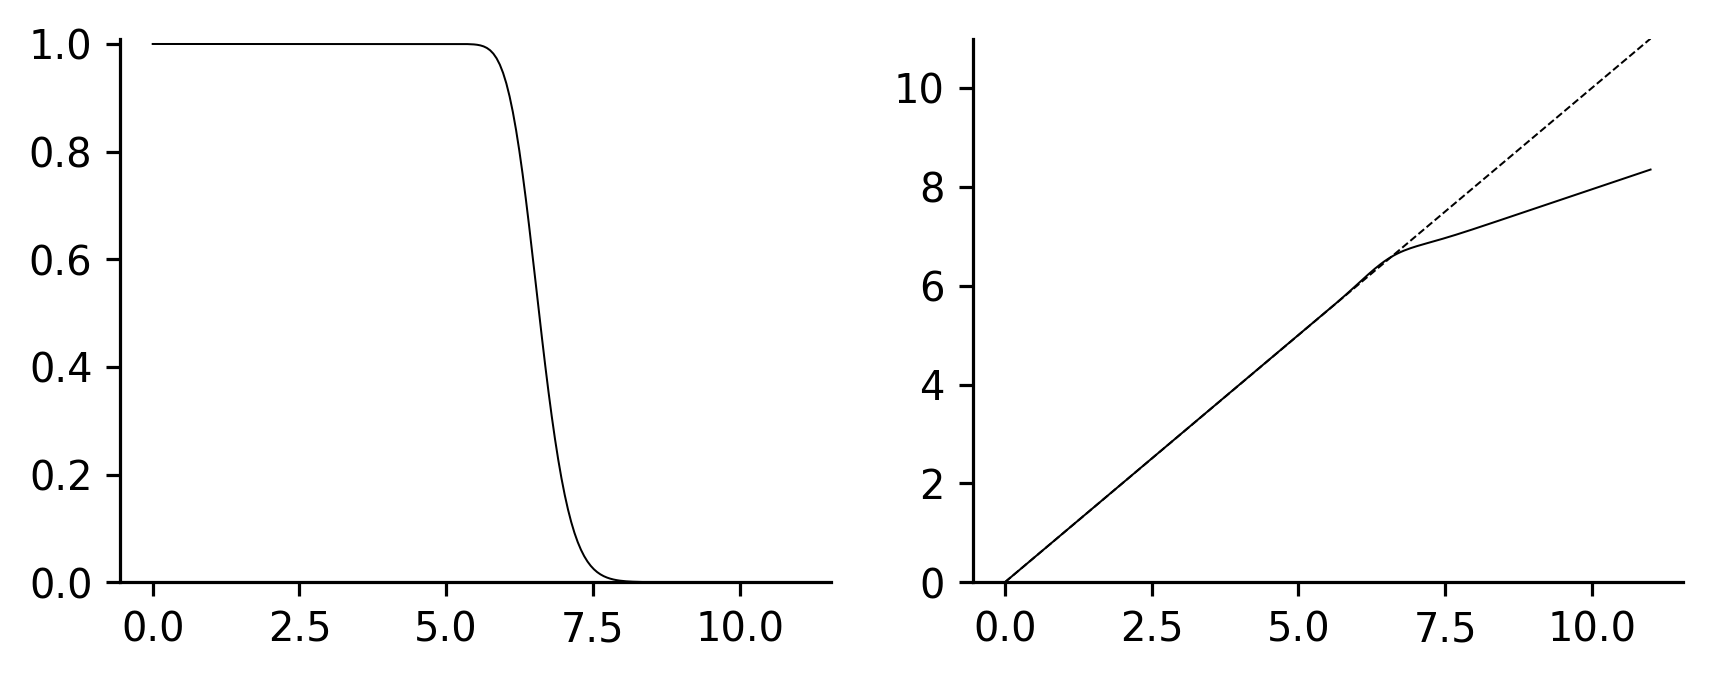

In [167]:
(fig,axs) = plt.subplots(1, 2, figsize=(7, 2.5), dpi=72*4)
#fig.subplots_adjust(0,0,1,1,0.25,0)
for ax in axs:
    for sp in ['top','right']:
        ax.spines[sp].set_visible(False)

rho = torch.tensor(np.linspace(0, 11, 200), dtype=torch.float)
# Simulate true pRF size for this rho value.
prfsz = 0.1 + rho*0.2

ax = axs[0]
w = rfmdl_stimweight(rho, prfsz, 8)
ax.plot(rho, w, 'k-', lw=0.5)
ax.set_ylim([0,1.01])

ax = axs[1]
ax.plot(rho, rho, 'k--', lw=0.5)
ax.plot(rho, rfmdl_meas_eccen(rho, prfsz, w, 8), 'k-', lw=0.5)
ax.set_ylim([0,11])

pass

###### Calculation and Plan Code

In [168]:
@pimms.calc('pred_eccen')
def calc_pred_eccen(eccen, prfsize, stim_weight, max_stim_eccen):
    '''
    Calculates the predicted eccentricity, which is based on both the true
    eccentricity ('eccen') and the stimulus.
    
    Efferent values:
     @ pred_eccen The predicted measurement of pRF eccentricity associated with
       each vertex, according to the retinotopy model. This is different from
       the 'eccen' value in that 'eccen' is the model's predicted true
       eccentricity while 'pred_eccen' is the model's prediction of the
       measured eccentricity.
    '''
    pe = rfmdl_meas_eccen(eccen, prfsize, stim_weight, max_stim_eccen)
    return {'pred_eccen': pe}

##### Variance Explained Model

###### Explanation

The variance explained by the model should be highest within a certain range of the stimulus. Given the `max_stim_eccen`, which is the maximum eccentricity of the stimulus, we can predict this range. Across the HCP subjects, variance explained $r$ is approximately equal to the following equation within the range of the stimulus, with $\omega$ indicating a gain that in the HCP data was approximately $0.55$:

$$ r^{(\hbox{stim})}(\rho; \omega) = \frac{\omega}{2} \left( 1 + \hbox{erf}(\rho - 0.8) / 0.4) \right) $$

Additionally, the variance explained will drop as eccentricity passes stimulus edge. As soon as the prediction of the measured pRF size drops to 0, the variance explained should also be 0, so we use the following:

$$ r^{(\hbox{peri})}_k(\theta, \rho; \psi, \omega) = \frac{\omega}{2} \left( 1 - \hbox{erf}((\rho - \psi) / s_k(\theta, \rho)) \right) $$

The overall variance explained model is just the product of these two:

$$ r_k(\theta, \rho; \psi, \omega) = \frac{r^{(stim)}(\rho; \omega) \, r^{(peri)}_k(\theta, \rho; \psi, \omega)}{\omega} $$

$$ r_k(\theta, \rho; \psi, \omega, \mu_r, \sigma_r) = \frac{\omega}{4} \, \left[ 1 + \hbox{erf}(\rho - \mu_r) / \sigma_r) \right] \, \left[ 1 - \hbox{erf}((\rho - \psi) / s_k(\theta, \rho)) \right] $$

Where $\mu_r$ and $\sigma_r$ are approximately $1$ and $1/2$, respectively, in the HCP dataset. These are referred to as `cod_eccen_mean` and `cod_eccen_std` in the code.

###### Core Functions

In [169]:
def r2mdl_stim_cod(rho, cod_eccen_mean=1.0, cod_eccen_std=0.5):
    '''
    Yields the stimulus variance explained value (r^(stim) in the above
      cell, without the omega multiplier).
    '''
    return (1 + torch.erf((rho - cod_eccen_mean) / cod_eccen_std)) / 2
def r2mdl_peri_cod(rho, prfsize, max_stim_eccen):
    '''
    Yields the peripheral variance explained value (r^(peri) in the above
      cell, without the omega multiplier).
    '''
    return (1 - torch.erf((rho - max_stim_eccen) / prfsize)) / 2
def r2mdl_meas_cod(rho, prfsize, max_stim_eccen,
                   omega=0.55, cod_eccen_mean=1.0, cod_eccen_std=0.5):
    '''
    Yields the predicted coefficient of determination of the measurement for
      the given eccentricity, prfsize, and maximum stimulus eccentricity.
    '''
    rstim = r2mdl_stim_cod(rho,
                           cod_eccen_mean=cod_eccen_mean,
                           cod_eccen_std=cod_eccen_std)
    rperi = r2mdl_peri_cod(rho, prfsize, max_stim_eccen)
    return omega * rstim * rperi

###### Demo

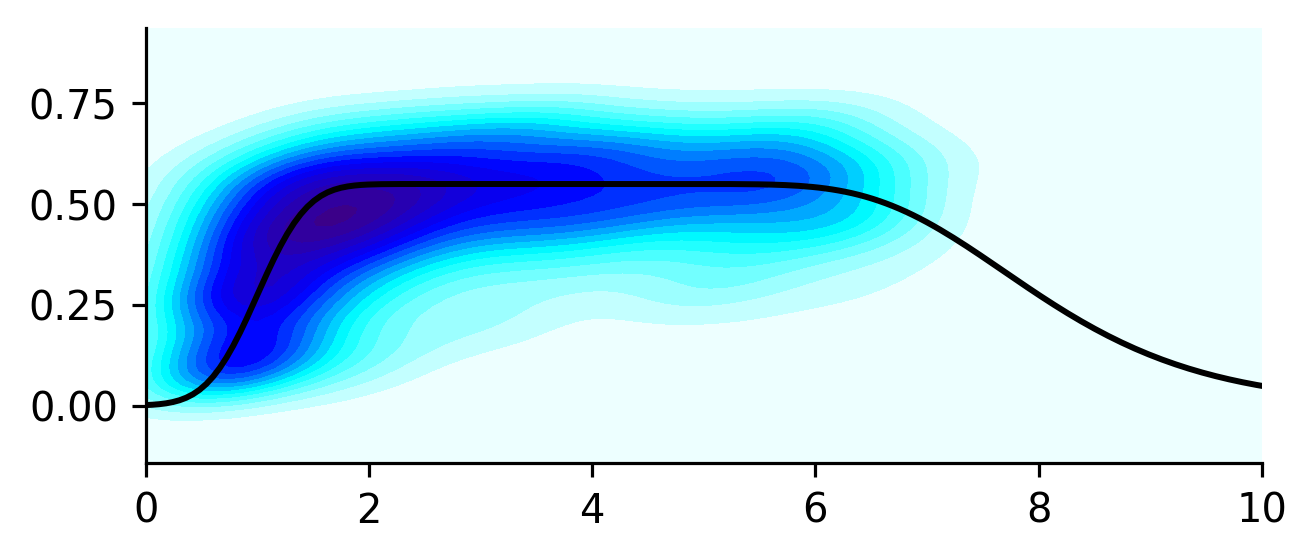

In [170]:
import seaborn as sns
import scipy as sp

(fig,ax) = plt.subplots(1,1, figsize=(5,2), dpi=72*4)
for s in ['top','right']:
    ax.spines[s].set_visible(False)

# Plot density of vexpl in terms of eccen:
df = data.dataframe
df = df.loc[df['visual_area'] == 1]
x = df['clean_eccentricity'].values
y = df['prf_variance_explained'].values
ii = np.where(np.isfinite(x) & np.isfinite(y))[0]
# Randomly select a subset of these:
ii = np.random.choice(ii, 2000, replace=False)
sns.kdeplot(x[ii], y[ii], ax=ax, shade=True, cmap='bluish',
            levels=20)
# Plot the predicted vexpl line. Note that the density
# plot doesn't include any values above 7.
x = torch.tensor(np.linspace(0,12,200), dtype=torch.float)
y = r2mdl_meas_cod(x, 0.1+0.2*x, 8)
ax.plot(x, y, 'k-')
ax.set_xlim([0,10])

pass

###### Calculation and Plan Code

In [171]:
@pimms.calc('cod_omega_free', 'cod_eccen_mean_free', 'cod_eccen_std_free')
def init_cod_params(dtype, gradients,
                    prior_cod_omega=(0.0, 0.55, 0.50, 0.45),
                    prior_cod_eccen_mean=1.0,
                    prior_cod_eccen_std=0.5,
                    cod_omega_lim=(0.01, 1.0),
                    cod_eccen_mean_lim=(0.1, 2.5),
                    cod_eccen_std_lim=(0.05, 1.25),
                    cod_grad=True):
    '''
    Initializes the model parameters required to calculate the coefficient of
    determination (variance explained) of each vertex and/or visual field
    position. This calculation initializes the "free" versions of the
    cod_omega, cod_eccen_mean, and cod_eccen_std parameters--i.e., the version
    that can range from -inf to inf but that gets limited into a particular
    range for the actual model calculation.
    
    Afferent parameters:
     @ prior_cod_omega The initial value of the omega parameter used in the
       coefficient of determination estimation. The omega value for a visual
       area is the maximum predicted variance-explained fraction for that
       visual area. This should be a tensor of 4 values for visual areas
       (none, v1, v2, v3).
     @ cod_omega_lim The (min, max) values that the cod_omega parameter is
       allowed to take in the retinotopy model.
     @ prior_cod_eccen_mean The initial value of the "eccentricity of mean COD"
       parameter. This parameter determines the point at which the COD has
       reached its half-max value in terms of eccentricity. This should be a
       tensor of 4 values for visual areas (none, v1, v2, v3) or a single value
       if they share a parameter.
     @ cod_eccen_mean_lim The (min, max) values that the cod_eccen_mean
       parameter is allowed to take in the retinotopy model.
     @ prior_cod_eccen_std The initial value of the "standard deviation of
       initial COD by eccentricity" parameter. This parameter determines the
       speed at which the predicted COD rises from the fovea. This should be a
       tuple of 4 values for visual areas (none, v1, v2, v3) or a single value
       if they share a parameter.
     @ cod_eccen_std_lim The (min, max) values that the cod_eccen_std
       parameter is allowed to take in the retinotopy model.
     @ cod_grad Whether the parameters involved in the COD calculation should
       be marked as part of the gradient.
       
    Efferent values:
     @ cod_omega_free The free/unlimited version of the COD omega, i.e., the
       maximum value the COD can take on. As a free parameter, the value may be
       any real number; the limited version is calculated using the acrtangent
       function.
     @ cod_eccen_mean_free The free/unlimited version of the "eccentricity of
       mean COD" parameter, i.e., the eccentricity at which the CDF first
       reaches its mean value. As a free parameter, the value may be any real
       number; the limited version is calculated using the acrtangent function.
     @ cod_eccen_std_free The free/unlimited version of the COD model parameter
       that determines the speed at which the COD reaches its max value in
       terms of eccentricity. As a free parameter, the value may be any real
       number; the limited version is calculated using the acrtangent function.   
    '''
    import torch
    tups = [
        ('cod_omega_free',      cod_omega_lim,      prior_cod_omega),
        ('cod_eccen_mean_free', cod_eccen_mean_lim, prior_cod_eccen_mean),
        ('cod_eccen_std_free',  cod_eccen_std_lim,  prior_cod_eccen_std)]
    rval = {}
    for (k,(mn,mx),pri) in tups:
        if np.shape(pri) == ():
            pri = (pri, pri, pri, pri)
        if len(pri) != 4:
            raise ValueError('prior for %s must be a length 4 tuple' % (k,))
        pri_free = unlimit_param(totensor(pri), mn, mx)
        if pri_free.shape == ():
            pri_free = torch.ones(4, dtype=dtype)*pri_free
        u = torch.tensor(pri_free.detach().numpy(),
                         dtype=dtype,
                         requires_grad=cod_grad)
        if cod_grad: gradients[k] = u
        rval[k] = u
    return rval
@pimms.calc('cod_omega', 'cod_eccen_mean', 'cod_eccen_std')
def calc_cod_params(cod_omega_free, cod_eccen_mean_free, cod_eccen_std_free,
                    cod_omega_lim,  cod_eccen_mean_lim,  cod_eccen_std_lim):
    '''
    Calculates the model parameters required to calculate the predicted 
    coefficient of determination of each vertex and/or visual field position.
    This calculation involves running the free versions of each pameter through
    the arctangent function in order to convert an infinite range to the range
    (0,1) then linearly expanding that to the parameter's limit.
    
    Efferent values:
     @ cod_omega The range-limited translation of the cod_omega_free
       parameter based on cod_omega_lim. The omega value for a visual
       area is the maximum predicted variance-explained fraction for that
       visual area. This parameter should be a 4-tensor of the parameters
       for the visual areas (none, v1, v2, v3).
     @ cod_eccen_mean The range-limited translation of the cod_eccen_mean_free
       parameter based on cod_eccen_mean_lim. This parameter determines the
       point at which the COD has reached its half-max value in terms of
       eccentricity. This should be a tensor of 4 values for visual areas
       (none, v1, v2, v3).
     @ cod_eccen_std The range-limited translation of the cod_eccen_std_free
       parameter based on cod_eccen_std_lim. This parameter determines the
       speed at which the predicted COD rises from the fovea. This should be a
       tuple of 4 values for visual areas (none, v1, v2, v3).
    '''
    tups = [(cod_omega_lim, cod_omega_free),
            (cod_eccen_mean_lim, cod_eccen_mean_free),
            (cod_eccen_std_lim, cod_eccen_std_free)]
    vals = [limit_param(free, mn, mx) for ((mn,mx),free) in tups]
    return tuple(vals)
@pimms.calc('pred_cod')
def calc_pred_cod(eccen, prfsizes, max_stim_eccen, dtype,
                  cod_omega, cod_eccen_mean, cod_eccen_std,
                  varea_weights):
    '''
    Calculates the COD or variance explained that is predicted to be measured
    by the retinotopy model.
    
    Efferent values:
     @ pred_cod The predicted coefficient of determination or variance
       explained value for each vertex.
    '''
    p = torch.zeros(eccen.shape, dtype=dtype)
    for (prfsize,om,mu,sig,wgt) in zip(prfsizes, cod_omega,
                                       cod_eccen_mean, cod_eccen_std,
                                       varea_weights):
        cod = r2mdl_meas_cod(eccen, prfsize, max_stim_eccen,
                             omega=om, cod_eccen_mean=mu, cod_eccen_std=sig)
        p += cod * wgt
    return (p,)

In [172]:
cod_plan = pimms.plan(
    {'init_cod_params': init_cod_params,
     'calc_cod_params': calc_cod_params,
     'calc_pred_cod': calc_pred_cod})

#### Likelihood Estimation

In [ ]:
@pimms.calc('zsign_exponent_free')
def init_zsign_params(dtype, device, gradients, zsign_grad=False,
                      prior_zsign_exponent=8, zsign_exponent_lim=(1,1e4)):
    '''
    Initializes the z-sign parameters.
    
    Afferent parameters:
     @ prior_zsign_exponent The prior value of the z-sign exponent.
     @ zsign_exponent_lim The (min, max) value that the z-sign exponent can
       take during optimization.
       
    Efferent values:
     @ zsign_exponent_free The free (unlimited) value of the z-sign exponent.
    '''
    zexp = totensor(prior_zsign_exponent, dtype=dtype, requires_grad=zsign_grad)
    (mn,mx) = zsign_exponen_lim
    zexp = unlimit_param(zexp, mn, mx)
    zexp = zexp.to(device)
    if zsign_grad:
        gradients['zsign_exponent_free'] = zexp
    return (zexp,)
@pimms.calc('zsign_exponent')
def prep_zsign_params(zsign_exponent_lim, zsign_exponent_free):
    '''
    Prepares the zsign_exponent value from the zsign_expoment_free value by
    limiting the latter using the arctan function and linearly expanding to the
    parameter range.
    '''
    (mn,mx) = zsign_exponen_lim
    zexp = limit_param(zsign_exponent_free, mn, mx)
    return (zexp,)
@pimms.calc('zsign_likelihood')
def calc_zsign_likelihood(zsign, zsign_exponent_lim, zsign_true=-1):
    '''
    Calculates the likelihood of the z-sign component of the retinotopy model.
    The z-sign is conceptually similar to the fieldsign but is not calculated
    using the visual x and y coordinates but rather the eccen and anglecoef
    coordinates.
    
    Efferent values:
     @ zsign_likelihood The log-likelihood score of the z-sign values.
    '''
    

##### Model Initializatioin and Preprocessing

In [173]:
if 'prior' not in locals() or 'flatmap' not in locals():
    retinotopy_model_plan = pimms.plan(
        init_subject_plan,
        anglecoef_plan,
        cmag_plan,
        prfsize_plan,
        cod_plan,
        calc_pred_eccen=calc_pred_eccen)
    p = retinotopy_model_plan(sid=111312, hemi='lh',
                              max_stim_eccen=8, gradient={})
    prior = ny.vision.predict_retinotopy(p['cortex'])
    flatmap = p['flatmap']

In [198]:
# Aggregate all of the plans into a single plan!
retinotopy_model_plan = pimms.plan(
    init_subject_plan,
    anglecoef_plan,
    cmag_plan,
    prfsize_plan,
    cod_plan,
    calc_pred_eccen=calc_pred_eccen)

In [199]:
p = retinotopy_model_plan(sid=111312, hemi='lh',
                          max_stim_eccen=8,
                          prior=prior,
                          precalc_flatmap=flatmap)

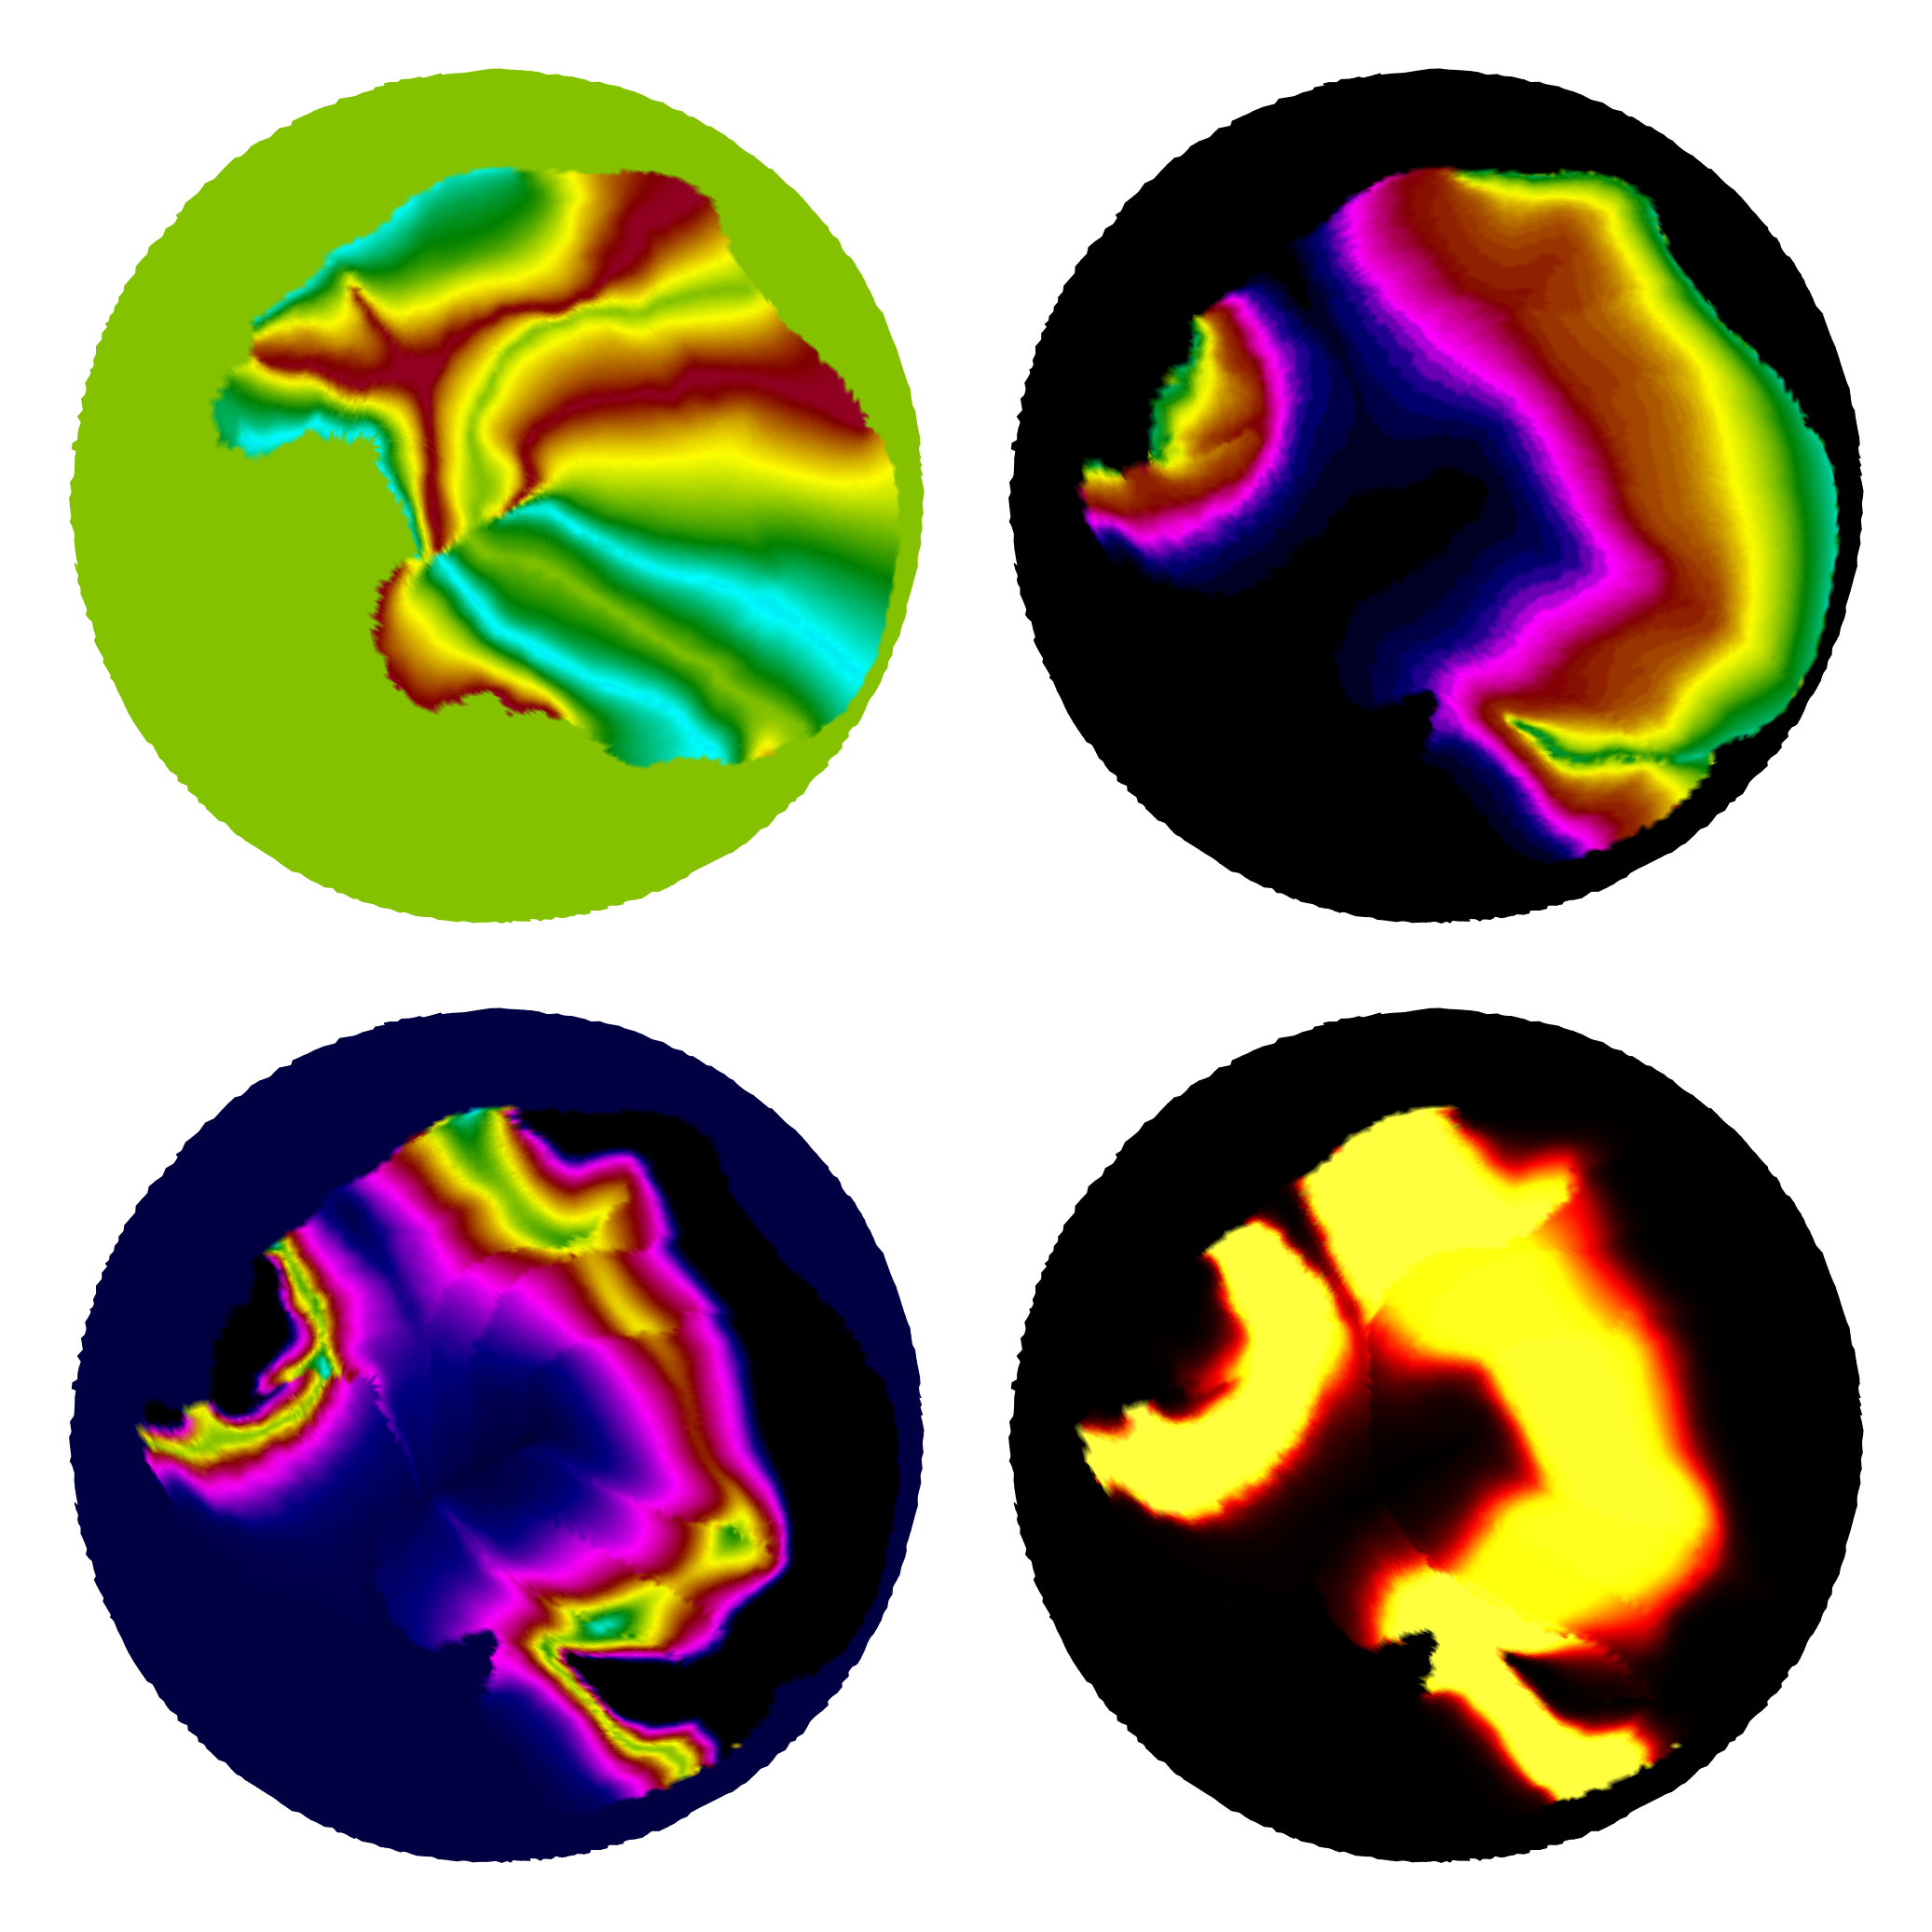

In [204]:
(fig,axs) = plt.subplots(2, 2, figsize=(7,7), dpi=72*4)
fig.subplots_adjust(0,0,1,1,0,0)

ax = axs[0,0]
ang = np.mod(90 - 180/np.pi*p['pred_theta'].detach().numpy() + 180, 360) - 180
ny.cortex_plot(p['flatmap'], color=ang, cmap='polar_angle',
               vmin=-180, vmax=180, axes=ax)

ax = axs[0,1]
x = p['pred_eccen'].detach().numpy()
ny.cortex_plot(p['flatmap'], color=x, cmap='eccentricity',
               vmin=0, vmax=90, axes=ax)

ax = axs[1,0]
x = p['pred_prfsize'].detach().numpy()
ny.cortex_plot(p['flatmap'], color=x, cmap='log_eccentricity',
               vmin=0, vmax=4, axes=ax)

ax = axs[1,1]
x = p['pred_cod'].detach().numpy()
ny.cortex_plot(p['flatmap'], color=x, cmap='reddish_dark',
               vmin=0, vmax=0.6, axes=ax)

for ax in axs.flatten():
    ax.axis('off')
    
pass

#### Model Loss Functions

These cells define loss functions which are to be minimized in order to maximize the model likelihood.

In [1249]:
def meas_loss(params):
    '''
    Calculates and inserts into the params the 'meas_loss' calculation of
    loss due to measurement disagreement.
    '''
    p_eccen = params['pmeas_eccen']
    m_eccen = params['meas_eccen']
    p_theta = params['theta']
    m_theta = params['meas_theta']
    p_vexpl = params['pmeas_vexpl']
    m_vexpl = params['meas_vexpl']
    vareas  = params['vareas']
    # First of all, we will use the predicted variance explained as
    # weight.
    weight = p_vexpl
    # The vexpl loss is modeled by a beta distribution whose variance
    # is higher (up to flat) when with the inverse of the vexpl itself.
    bdist = beta_dist(pmeas_vexpl, 1 - pmeas_vexpl)
    bdist_max = bdist.log_prob(pmeas_vexpl)
    vexpl_loss = bdist_max - pmeas_vexpl

In [ ]:
# Reset the parameters to be prepared for a new iteration.
def p_reset(params):
    # Copy the parameters
    p = copy.copy(params)
    # Remove any of the old temporary/cache values.
    for k in params.keys():
        if k.startswith('_'):
            del p[k]
    return p

In [ ]:
def viselen2(x, y):
    return (x[u] - x[v])**2 + (y[u] - y[v])**2
def viselen(x, y):
    return toch.sqrt(visdist2(x, y))
def visarea2(x, y):
    (xa,xb,xc,ya,yb,yc) = (x[a],x[b],x[c],y[a],y[b],y[c])
    # Side lengths
    sa = safesqrt((xb - xc)**2 + (yb - yc)**2)
    sb = safesqrt((xa - xc)**2 + (ya - yc)**2)
    sc = safesqrt((xb - xa)**2 + (yb - ya)**2)
    hp = 0.5*(sa + sb + sc)
    return hp * (hp - sa) * (hp - sb) * (hp - sc)
def visarea(x, y):
    return safesqrt(visarea2(x, y))
def linearcmag(x, y):
    return srfdist / visdist(x,y)
def arealcmag2(x, y):
    return srfarea / visarea(x,y)
def linearvmag(x, y):
    return visdist(x,y) / srfdist
def arealvmag2(x, y):
    return visarea(x,y) / srfarea

In [733]:


# Calculating Cortical Magnification.
def visangle(x, y, ui=0.09, li=0.17):
    t = torch.atan2(y, x)
    q = (t > 0) * (np.pi/2 + ui) + (t <= 0) * (np.pi/2 + li)
    return t / q * np.pi/2
def cmag_linecc(x, y, c1=17.3, c2=0.75):
    if not torch.is_tensor(c1): c1 = torch.tensor(c1)
    if len(c1.shape) > 0: (c1,c2) = c1[:2]
    return c1 / (c2 + torch.sqrt(x**2 + y**2))
def cmag_linang(x, y, hva=0.5, vma=0.5, ui=0.09, li=0.17):
    if not torch.is_tensor(hva): hva = torch.tensor(hva)
    if len(hva.shape) > 0: (hva,vma,ui,li) = hva[2:]
    t = visangle(x, y, ui=ui, li=li)
    hva = (hva/(2*np.pi)) * torch.cos(2*t)
    vma = (vma/(2*np.pi)) * (1 - torch.sin(t))
    return 1.0/np.pi + hva + vma
def cmag_lin(x, y, c1=17.3, c2=0.75, hva=0.5, vma=0.5, ui=0.09, li=0.17):
    ecc = cmag_linecc(x, y, c1=c1, c2=c2)
    ang = cmag_linang(x, y, hva=hva, vma=vma, ui=ui, li=li)
    return ecc*ang
def cmag_areal(x, y, c1=17.3, c2=0.75, hva=0.5, vma=0.5, ui=0.09, li=0.17):
    return cmag_lin(x, y, c1=c1, c2=c2, hva=hva, vma=vma, ui=ui, li=li)**2
# The cortical magnification should be smooth.
def cmag_predict(x, y, c1=17.3, c2=0.75, hva=0.5, vma=0.5, ui=0.09, li=0.17):
    # Find the mean x/y values for the faces
    fx = (x[a] + x[b] + x[c]) / 3.0
    fy = (y[a] + y[b] + y[c]) / 3.0
    # Predicted cmag for each face
    return cmag_areal(fx, fy, c1=c1, c2=c2, hva=hva, vma=vma, ui=ui, li=li)

# Create (and track) a specific derived value during a potential computation.
def p_eccen(params): return params['eccen']
def p_angle(params): return params['angle']
def p_unlim(params): return params['unlim']
# (The rest are derived values.)
def p_limit(params):
    lim = params.get('limit', None)
    if lim is None:
        unlim = p_unlim(params)
        params['limit'] = lim = limit_param(unlim)
    return lim
def p_theta(params):
    th = params.get('theta', None)
    if 'theta' not in params:
        ang = p_angle(params)
        lbl = torch.abs(ang) / 360
        th = np.pi/180 * (90 - ang)
        params['theta'] = th
    return th
def p_x(params):
    if 'x' not in params:
        params['x'] = params['eccen'] * torch.cos(param_theta(params))

In [ ]:
def cmag_potential(x, y, c1=17.3, c2=0.75, hva=0.5, vma=0.5, ui=0.09, li=0.17):
    # Predicted cmag for each face
    fcm = cmag_predict(x, y, c1=c1, c2=c2, hva=hva, vma=vma, ui=ui, li=li)
    # The cmag as measured from the x/y positions
    rvm = arealvmag2(x, y)
    # The potential is the square of the difference of logs.
    return torch.sum((rvm - 1.0/fcm)**2) / len(a)

# The measured potential.
def meas_potential(x, y, maxeccen=8):
    # We want to down-weight anything predicted to be above the max-eccen.
    weights = torch.ones(x.shape)
    eccen = safesqrt(x**2 + y**2)
    weights = torch.erf((maxeccen - eccen) * 2)# * torch.erf(x *2)
    # Scores are inverted Gaussians.
    scores = 1.0 - torch.exp(-0.5 * ((x - vis_xM)**2 + (y - vis_yM)**2))
    return torch.sum(scores * weights) / torch.sum(weights)

# The smoothness potential.
def smooth_potential(x, y):
    # The values themselves should be smooth; eccen-scaled smoothness:
    elen2 = (x[u] - x[v])**2 + (y[u] - y[v])**2
    eccen = 0.5*(safesqrt(x[u]**2 + y[u]**2) + safesqrt(x[v]**2 + y[v]**2))
    d0smooth = torch.sum(elen2 / eccen) / len(u)
    # The visual magnification should also be smooth:
    #vm = arealvmag2(x, y)
    #d1smooth = torch.sum((vm[f1] - vm[f2])**2) / len(f1)
    return d0smooth #+ d1smooth
# The cortical magnification should also be smooth

#### Scratch

In [1470]:
sid = 111312
hemi = 'lh'
q = init_subject_plan(sid=sid, hemi=hemi)
prior = ny.vision.predict_retinotopy(q['cortex'])
flatmap = q['flatmap']

IndexError: tuple index out of range

In [734]:
x = torch.tensor(np.array(vis_x0.detach()), requires_grad=True)
y = torch.tensor(np.array(vis_y0.detach()), requires_grad=True)
q = unlimit_params(torch.tensor([15.3, 0.75, 0.5, 0.5, 0.09, 0.17]))
q = torch.tensor(q.detach().numpy(), requires_grad=True)
def paramdict():
    return {'x': np.array(x.detach().numpy()),
            'y': np.array(y.detach().numpy()),
            'q': np.array(limit_params(q).detach().numpy())}

# Store the initial parameters.
start_params = final_params = paramdict()
opt = None
def closure(zero=True):
    if zero: opt.zero_grad()
    s = limit_params(q)
    loss = cmag_potential(x, y, s) + 0.01*meas_potential(x, y) + smooth_potential(x, y)
    if zero: loss.backward()
    return loss
param_record = []
doSGD = False
for rr in range(3):
    opt = torch.optim.LBFGS([x, y], lr=0.1/np.exp(rr))
    print("Round: %d" % (rr+1))
    print("  Part 1 (LBFGS)")
    for ii in range(100):
        if ii % 5 == 0: print('    %4d' % (ii,), closure(False).item())
        param_record.append(final_params)
        opt.step(closure)
        final_params = paramdict()
    if doSGD:
        opt = torch.optim.SGD([x, y, q], lr=0.01/np.exp(rr))
        print("  Part 2 (SGD)")
        for ii in range(1000):
            if ii % 50 == 0: print('    %4d' % (ii,), closure(False).item())
            param_record.append(final_params)
            opt.step(closure)
            final_params = paramdict()

pass

Round: 1
  Part 1 (LBFGS)
       0 1928.3683756999399
       5 59.91809645661304
      10 11.30403231978795
      15 5.063741441477168
      20 3.140844607606387
      25 2.3670202986663362
      30 1.87344989054924
      35 1.5983640608153173
      40 1.3784597032743728
      45 1.2409780311228924
      50 1.1191350752361222
      55 1.0201959741925044
      60 0.9529300712863993
      65 0.9009766675469546
      70 0.8561225823104903
      75 0.817673918695536
      80 0.788020677889314
      85 0.765198991639664
      90 0.7426510924682137
      95 0.7197420526991849
Round: 2
  Part 1 (LBFGS)
       0 0.6990944313557601
       5 0.6940524309250027
      10 0.6868287058094688
      15 0.6786894746164748
      20 0.6677955768320329
      25 0.6569860831495468
      30 0.6480625215601366
      35 0.6393966455318141
      40 0.630628992944951
      45 0.6211811515255572
      50 0.6105402836619245
      55 0.5979930517039022
      60 0.5859913648747724
      65 0.5757910562579043
      

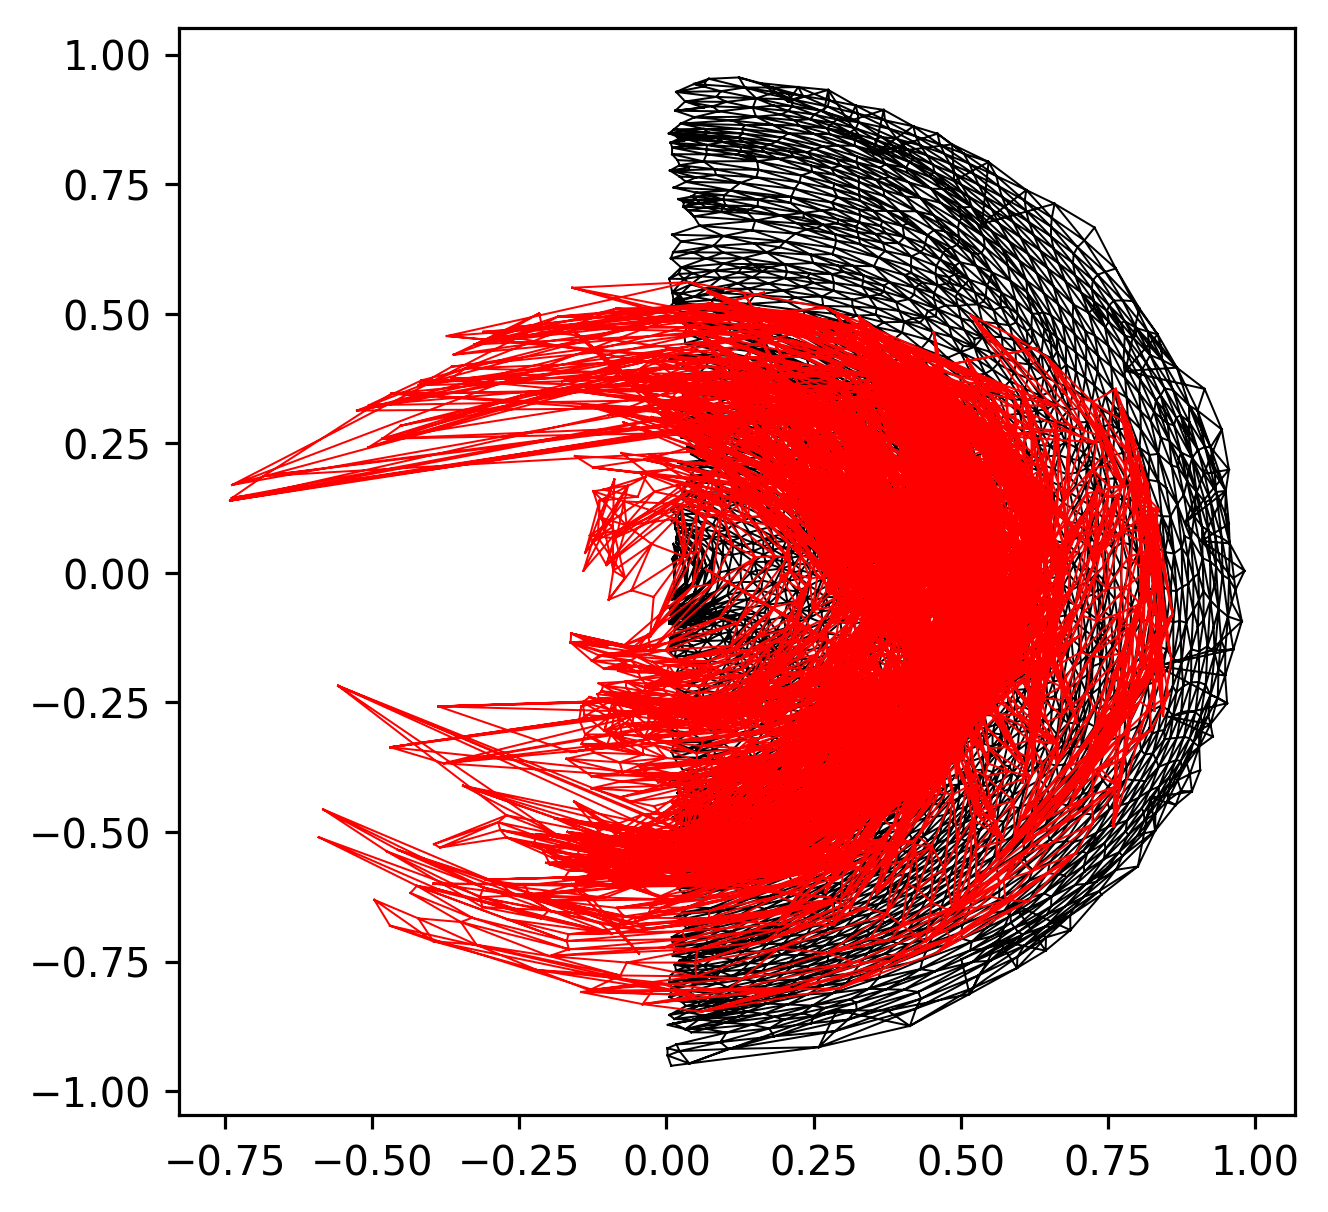

In [731]:
tris = optmap.tess.indexed_faces.T

(fig,ax) = plt.subplots(1,1, figsize=(5,5), dpi=72*4)

(x,y,q) = [start_params[k] for k in ('x','y','q')]
(x,y) = ny.to_logeccen([x,y])
tri = mpl.tri.Triangulation(x, y, tris)
ax.triplot(tri, 'k-', lw=0.5)

#p = param_record[4509]
p = final_params
(x,y,q) = [p[k] for k in ('x','y','q')]
(x,y) = ny.to_logeccen([x,y])
tri = mpl.tri.Triangulation(x, y, tris)
ax.triplot(tri, 'r-', lw=0.5)

#ax.set_xlim([-9,9])
#ax.set_ylim([-9,9])

pass

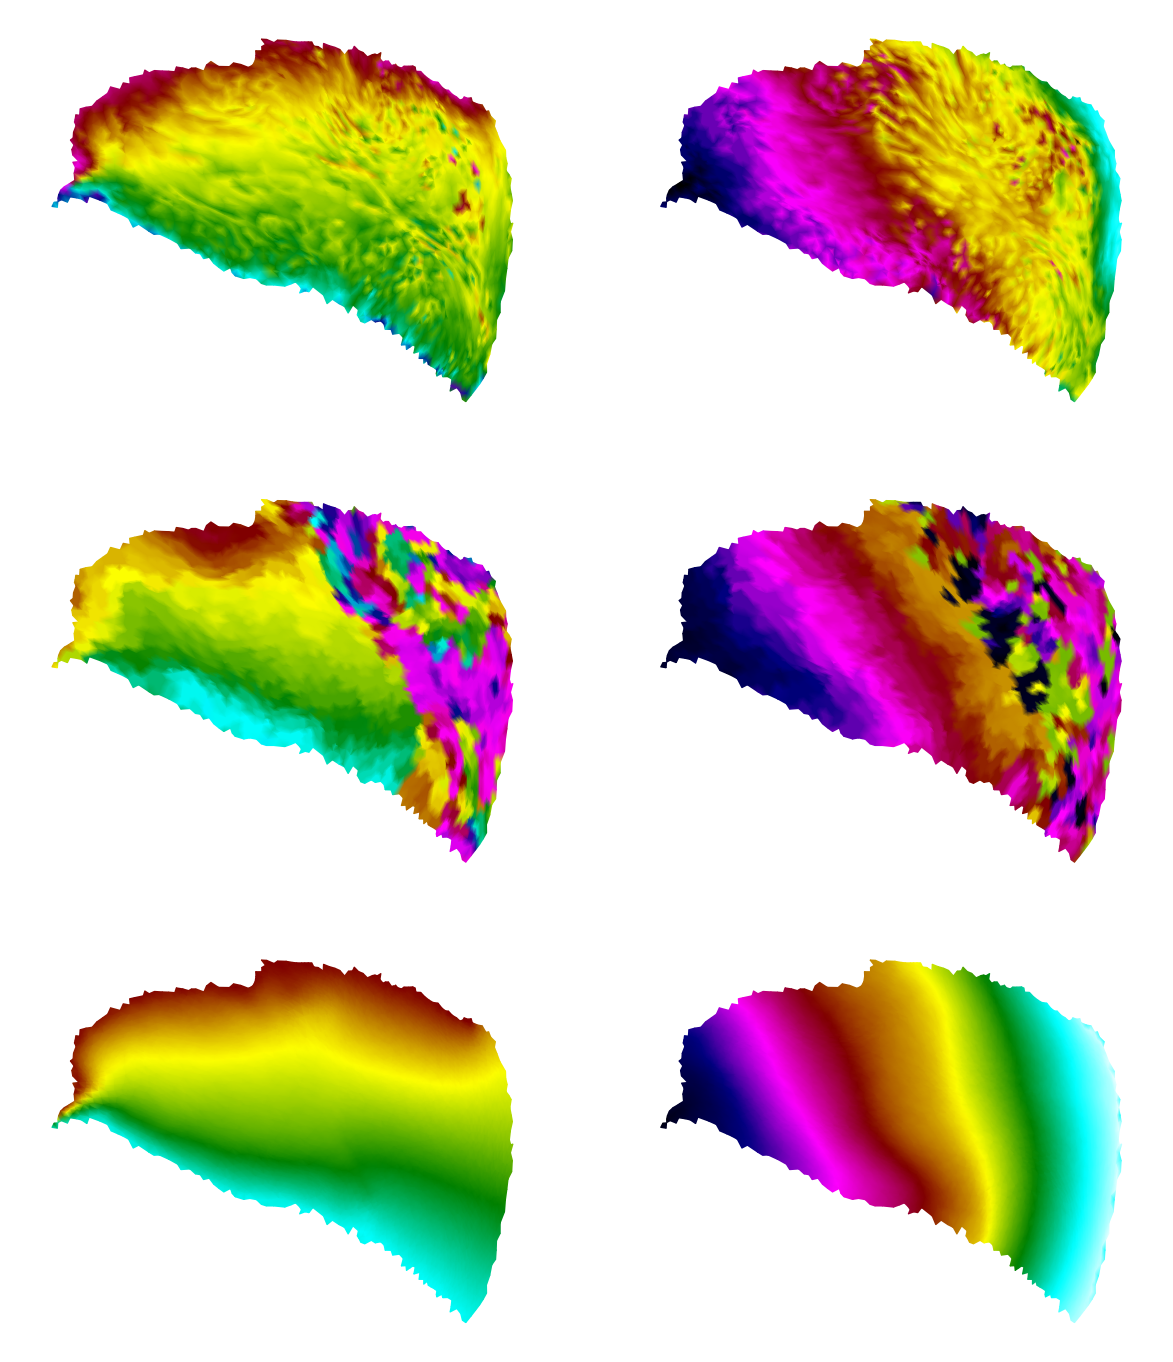

In [732]:
(fig,axs) = plt.subplots(3, 2, figsize=(5,6), dpi=72*4)

p = final_params
(x,y,q) = [p[k] for k in ('x','y','q')]
ang = np.arctan2(y, x)
ang = np.mod(90 - 180/np.pi*ang + 180, 360) - 180
ecc = np.sqrt(x**2 + y**2)

ny.cortex_plot(fm, axes=axs[0,0], color=ang, cmap='polar_angle', vmin=-180, vmax=180)
ny.cortex_plot(fm, axes=axs[0,1], color=ecc, cmap='eccentricity', vmin=0, vmax=90)
ny.cortex_plot(fm, axes=axs[1,0], color='prf_polar_angle')
ny.cortex_plot(fm, axes=axs[1,1], color='prf_eccentricity')
ny.cortex_plot(fm, axes=axs[2,0], color='b14_polar_angle')
ny.cortex_plot(fm, axes=axs[2,1], color='b14_eccentricity')
for ax in axs.flatten():
    ax.axis('equal')
    ax.axis('off')